# Estimate responses from abrupt CO2 change experiments, with oscillation on intermediate (decadal-scale) mode

## This file should be updated to use the functions defined in "my_functions"

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from scipy import optimize
from lmfit import Model
import matplotlib.gridspec as gridspec
plt.rcParams.update({'figure.max_open_warning': 0})

exp = 'abrupt-4xCO2'

# define response functions
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2
def exp_part1(t, S1, tau1):
    return S1*(1 - np.exp(-t/tau1))
def exp_part2(t, S2, tau2):
    return S2*(1 - np.exp(-t/tau2))

def oscillatory_model(t, S1, S2, Sosc1, Sosc2, tau1, tau2, taup, Tq):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + osc_parts(t, Sosc1, Sosc2, taup, Tq)

# create models for total response and the components
gmodel = Model(oscillatory_model)
oscmodel = Model(osc_parts); expmodel1 = Model(exp_part1); expmodel2 = Model(exp_part2)

# make functions and models for the TOA imbalance components
def oscN_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = - Sosc1*np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t))
    osc_part2 = - Sosc2*np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t))
    return osc_part1 + osc_part2
def expN_part1(t, S1, tau1):
    return -S1*np.exp(-t/tau1)
def expN_part2(t, S2, tau2):
    return -S2*np.exp(-t/tau2)

oscNmodel = Model(oscN_parts); expNmodel1 = Model(expN_part1); expNmodel2 = Model(expN_part2)

In [2]:
#model = 'ACCESS-CM2'; member = 'r1i1p1f1'
#model = 'CESM2'; member = 'r1i1p1f1'
#model = 'GISS-E2-1-G'; member = 'r1i1p1f1'
#model = 'TaiESM1'; member = 'r1i1p1f1'

In [3]:
model_anom_names = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/') if f.is_dir() and f.name !='.ipynb_checkpoints']
model_anom_names.sort()

member_dict = {}
for model in model_anom_names:
    anom_exp = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in anom_exp: # which members do we have?
        filenames = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/' + model + '/' + exp) if f.name !='.ipynb_checkpoints']
        members = [file.rsplit('_')[2] for file in filenames]
        members.sort()
        member_dict[model] = members


In [4]:
member_dict;

## Estimate responses

ACCESS-CM2
-0.5165205763598184
ACCESS-ESM1-5
-0.8616452116259659
AWI-CM-1-1-MR
-1.5406320568639273
BCC-CSM2-MR
-1.309362435659712
BCC-ESM1
-1.0060343149911333
CAMS-CSM1-0
-1.9645371409321117
-2.2407182185615544
CAS-ESM2-0
-0.748427150850981
CESM2
-0.8808861522890963
CESM2-FV2
-0.4619273361331917
CESM2-WACCM
-0.3675374388437893
CESM2-WACCM-FV2
-0.2062159047784471
CIESM
-1.1866597756979145
CMCC-CM2-SR5
-1.7375646577624182
CNRM-CM6-1
-0.5475546815377115
CNRM-CM6-1-HR
-0.6321702861524869
CNRM-ESM2-1
-1.1301280050863296
-0.26136330897718185
-0.21265265577118964
CanESM5
-0.7189153980264864
-0.7066488631256593
E3SM-1-0
-0.7436498946523686
EC-Earth3
-0.5948360552565042
-0.6130812937137922
EC-Earth3-Veg
-0.666963630645113
FGOALS-f3-L
-2.0273619964638185
-1.546607994924289
-1.8519531900038273
FGOALS-g3
-1.6456779883639623
FIO-ESM-2-0
-0.9530238407059155
-0.4448200565896361
-0.7710364542015524
GFDL-CM4
-0.904181098619933
GFDL-ESM4
-1.2515528597246455
GISS-E2-1-G
-1.6670358186854681
-1.62350038954

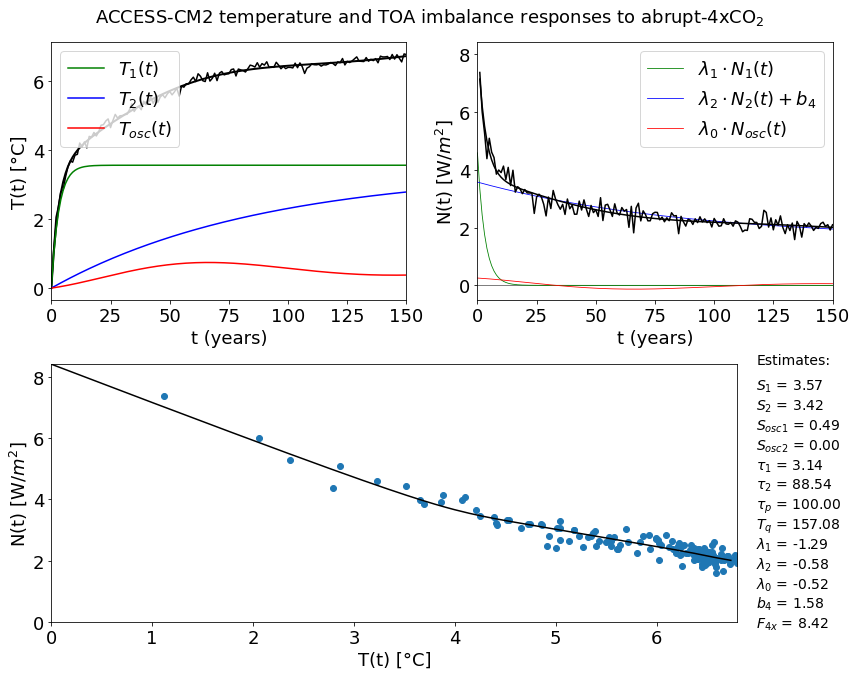

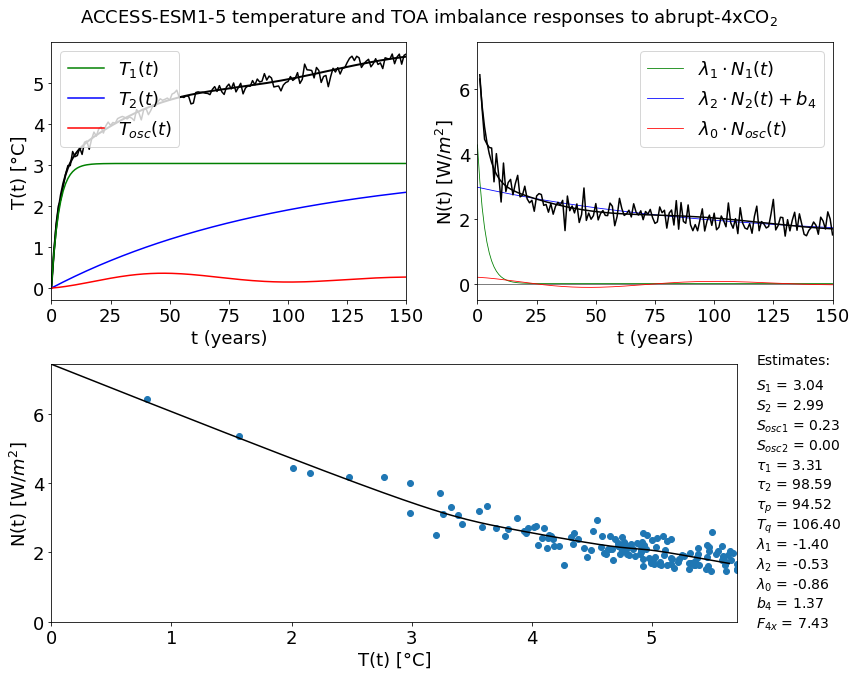

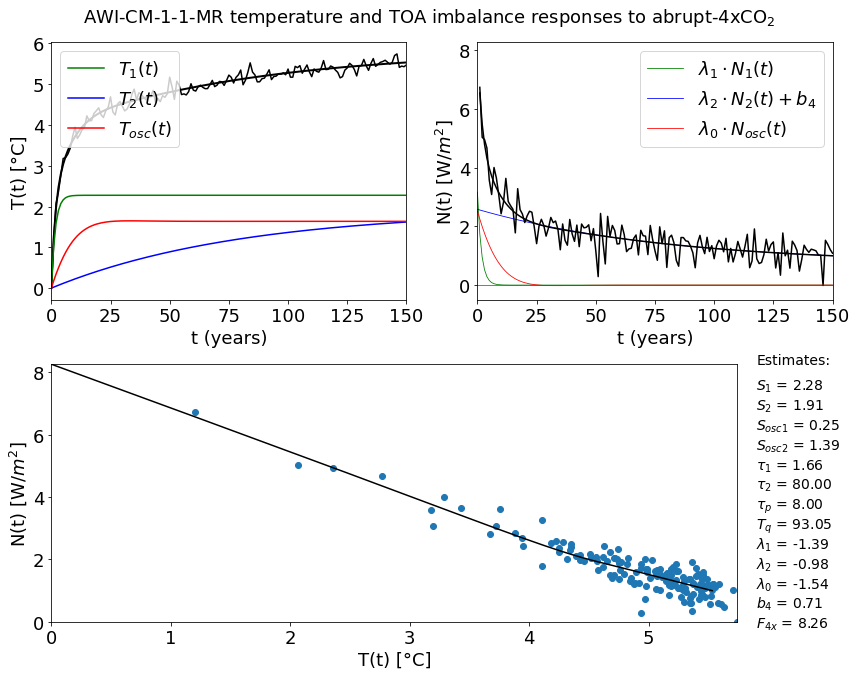

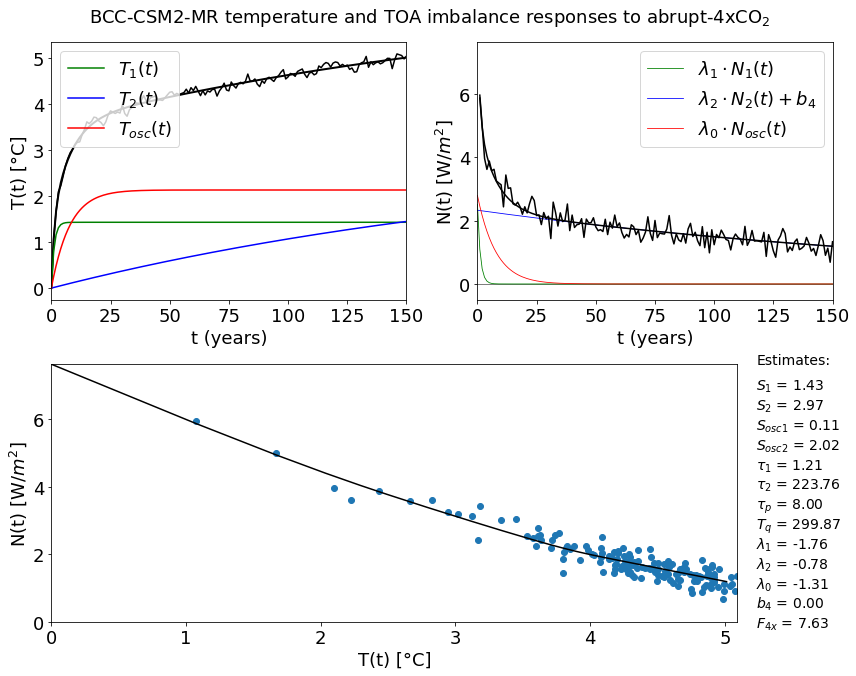

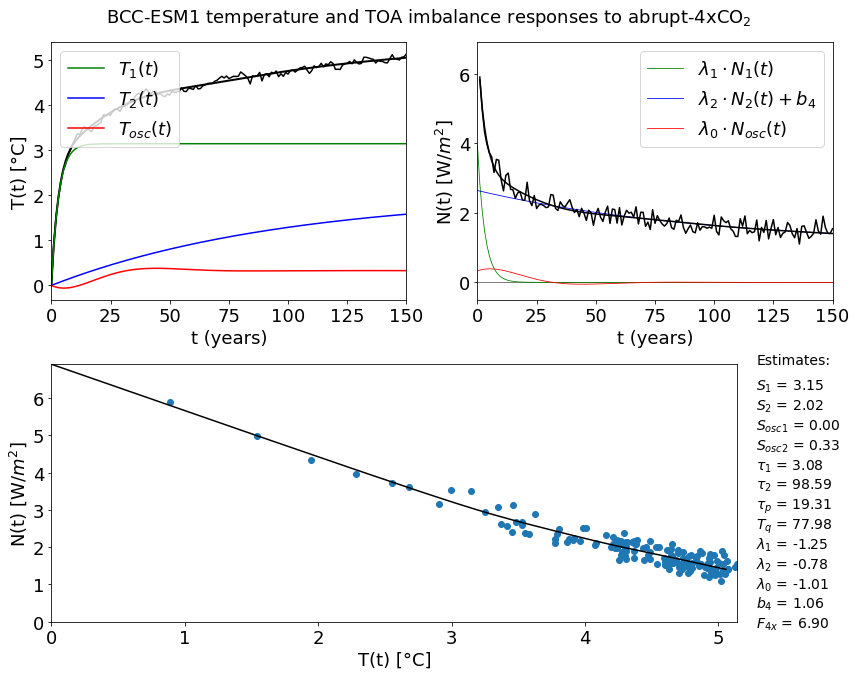

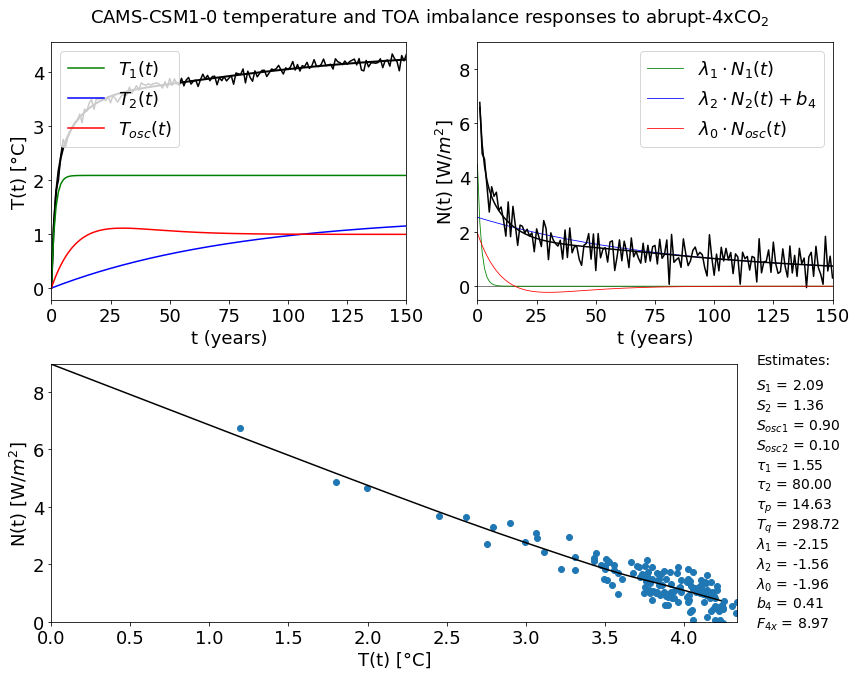

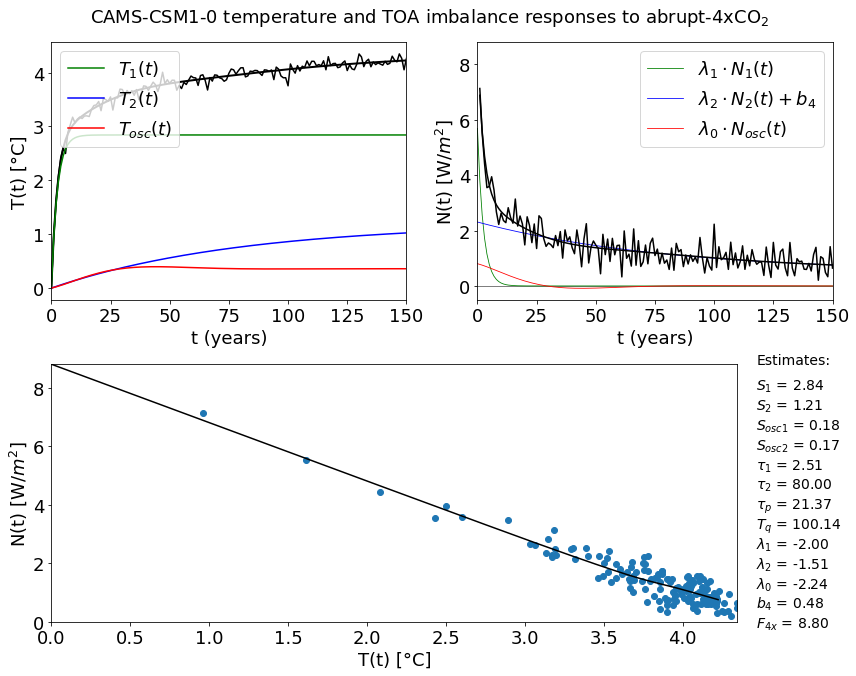

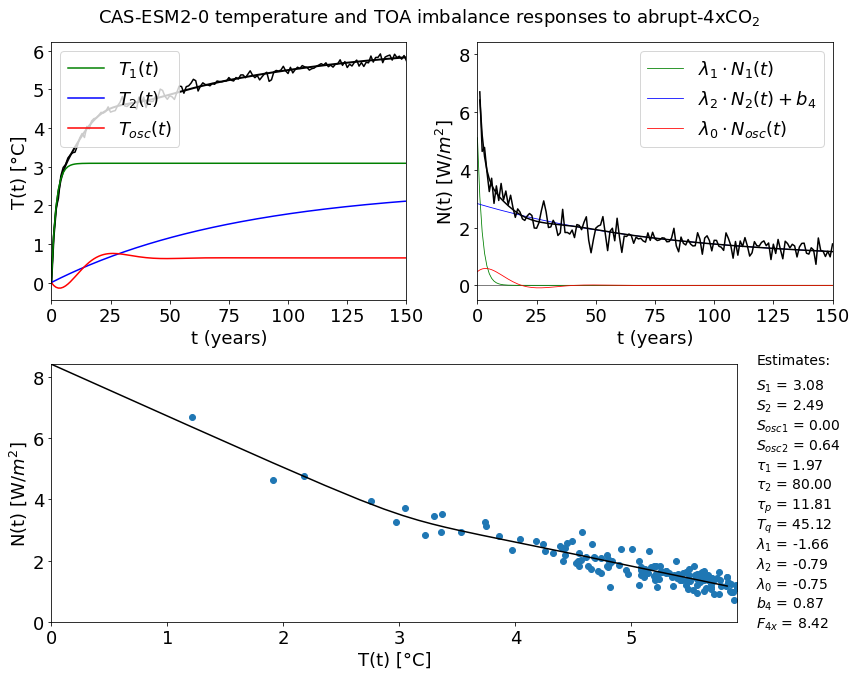

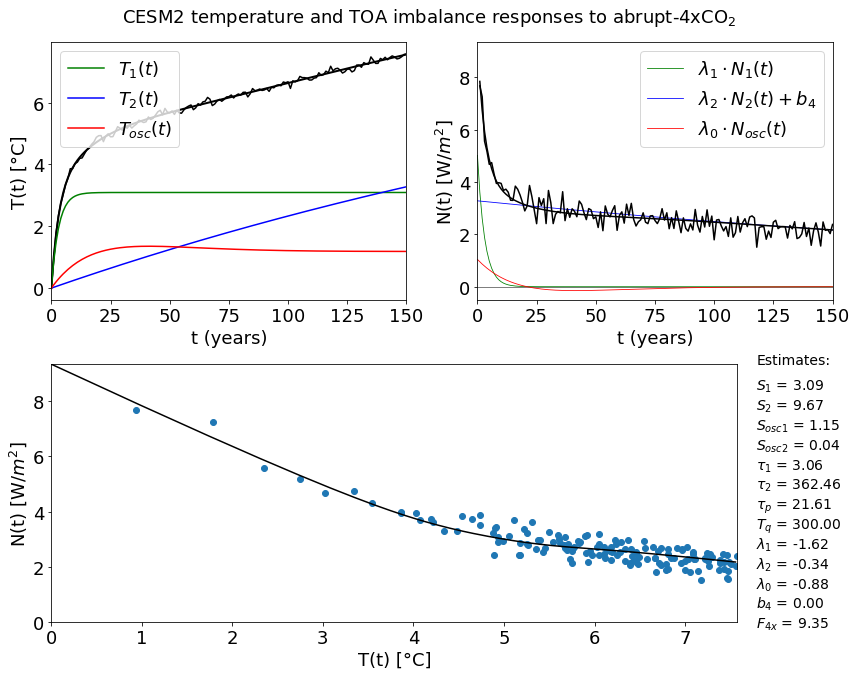

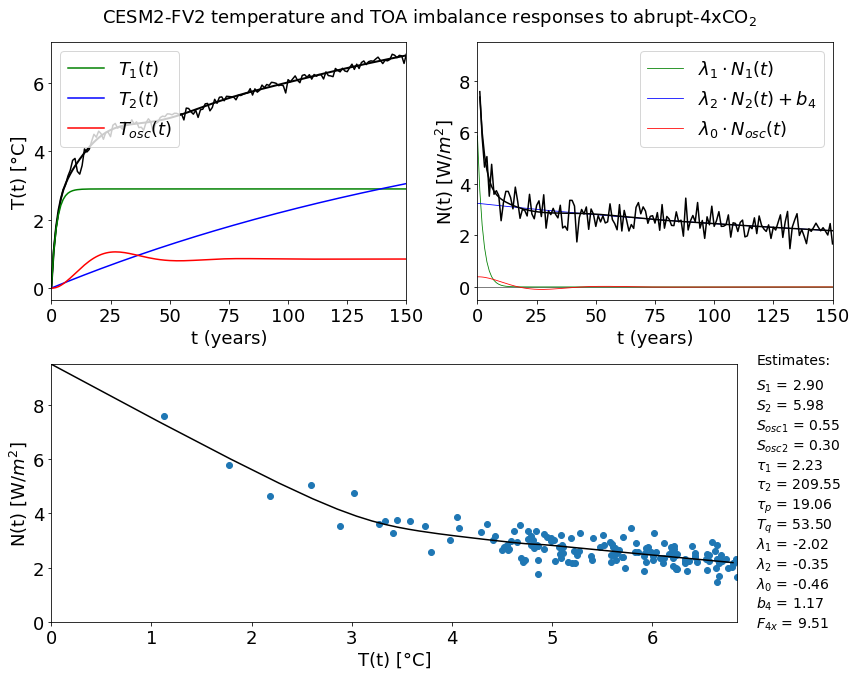

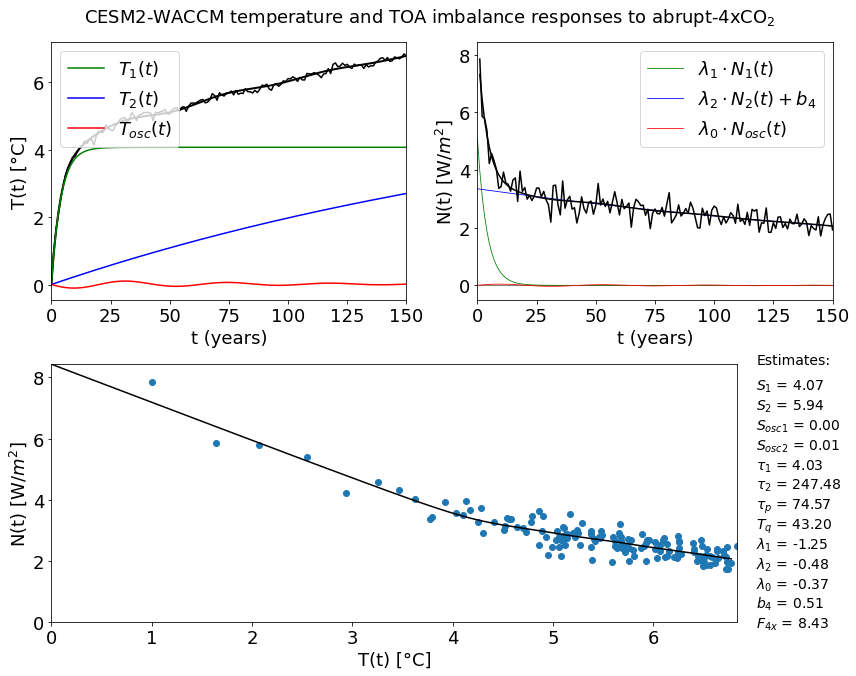

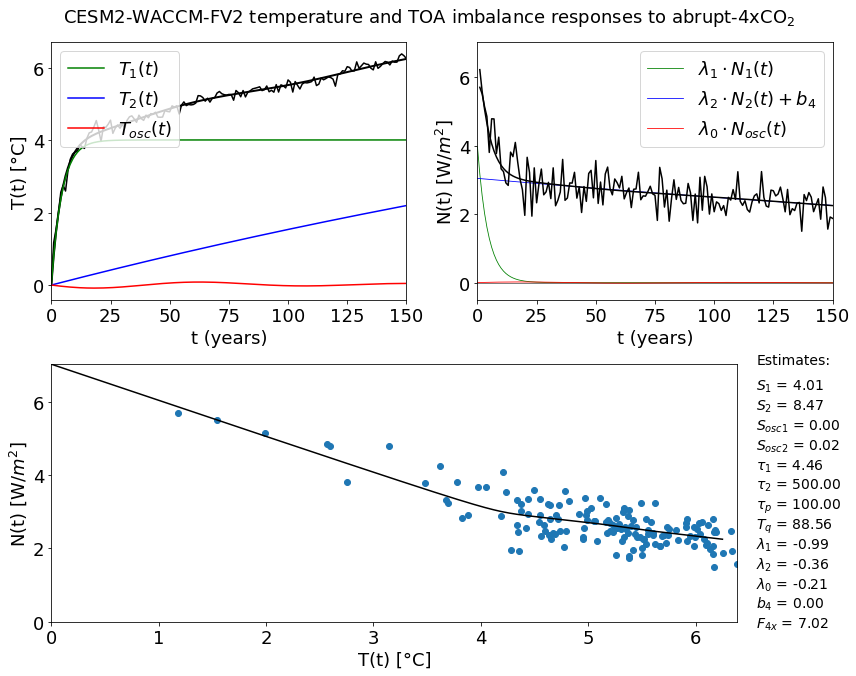

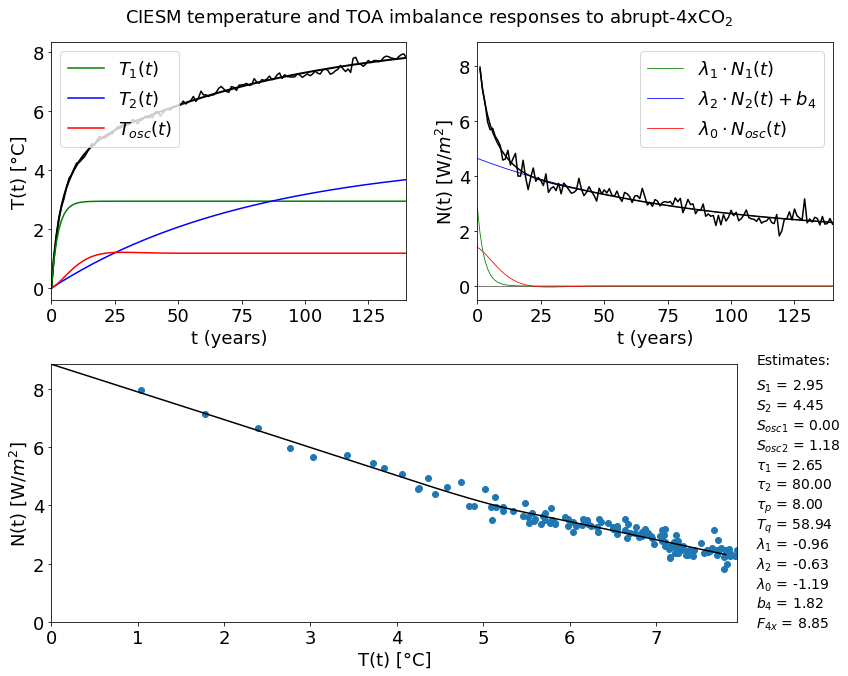

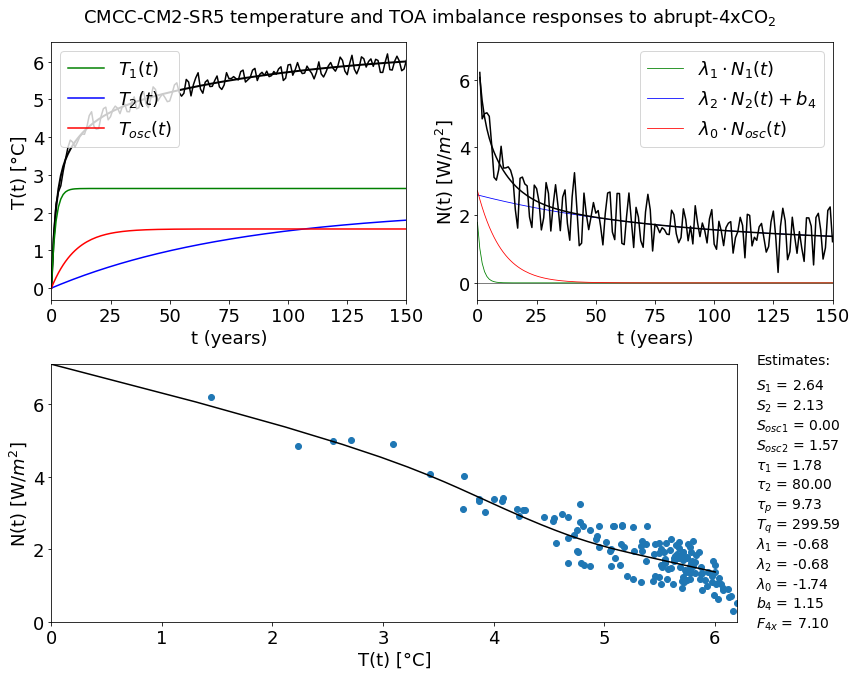

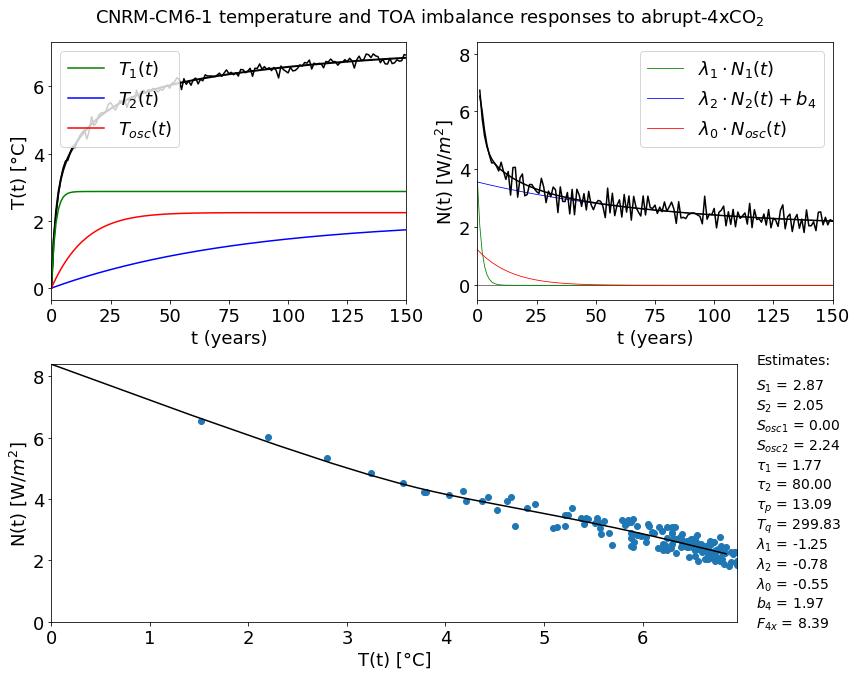

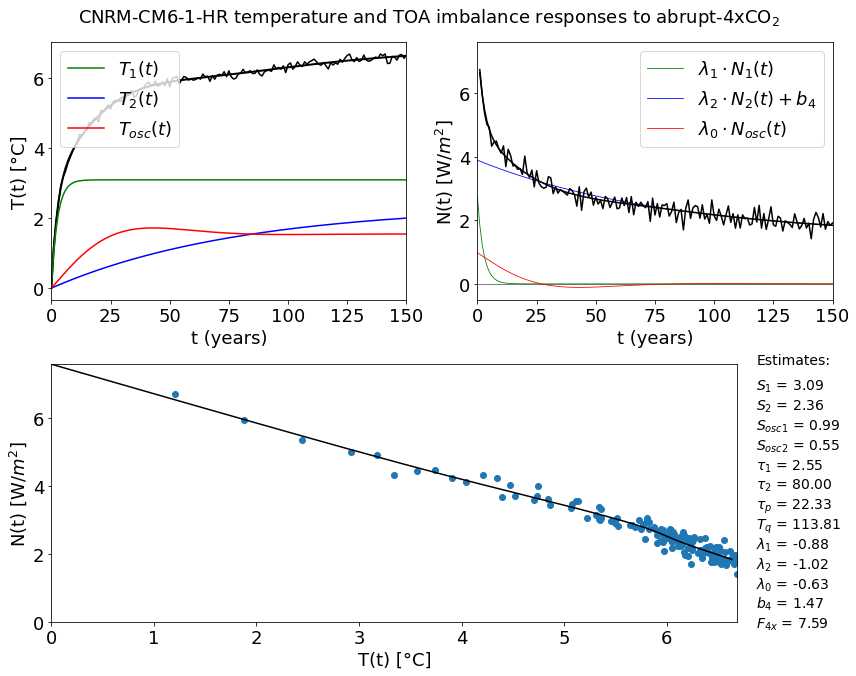

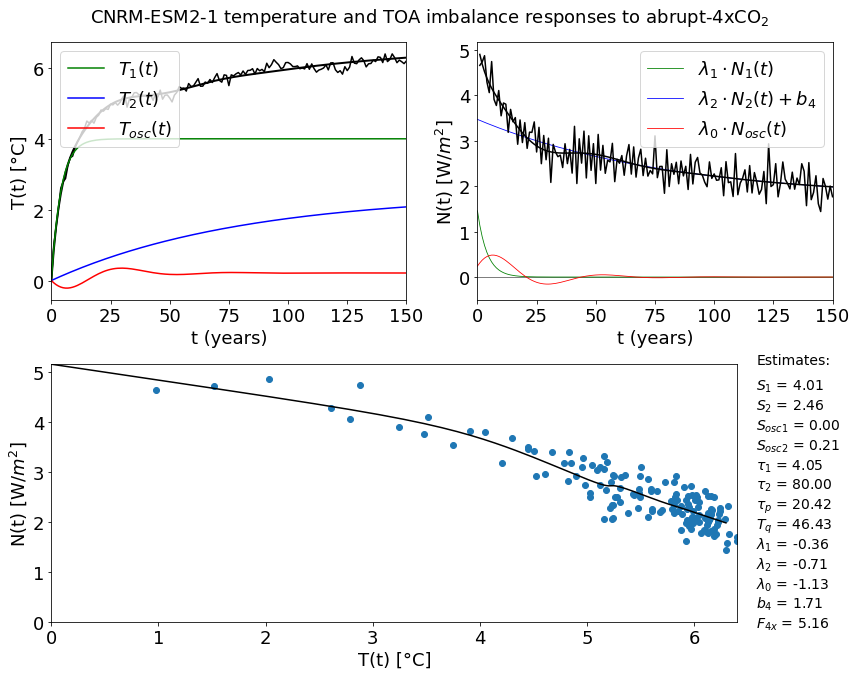

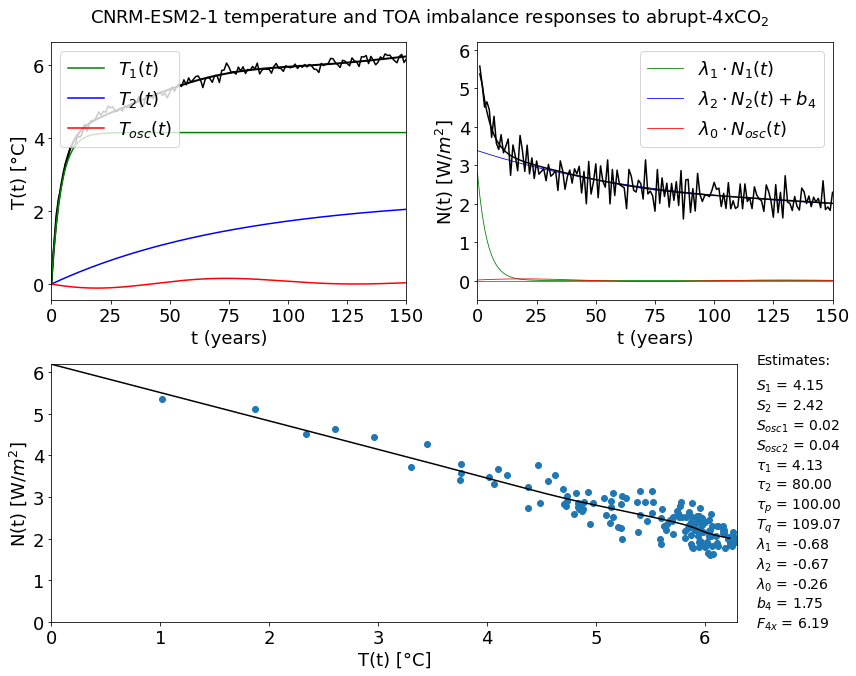

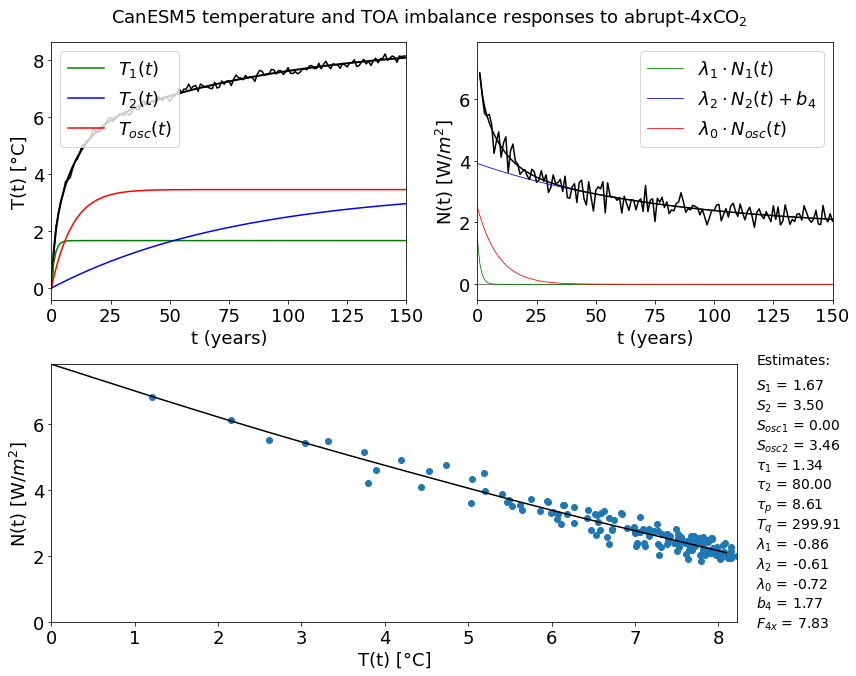

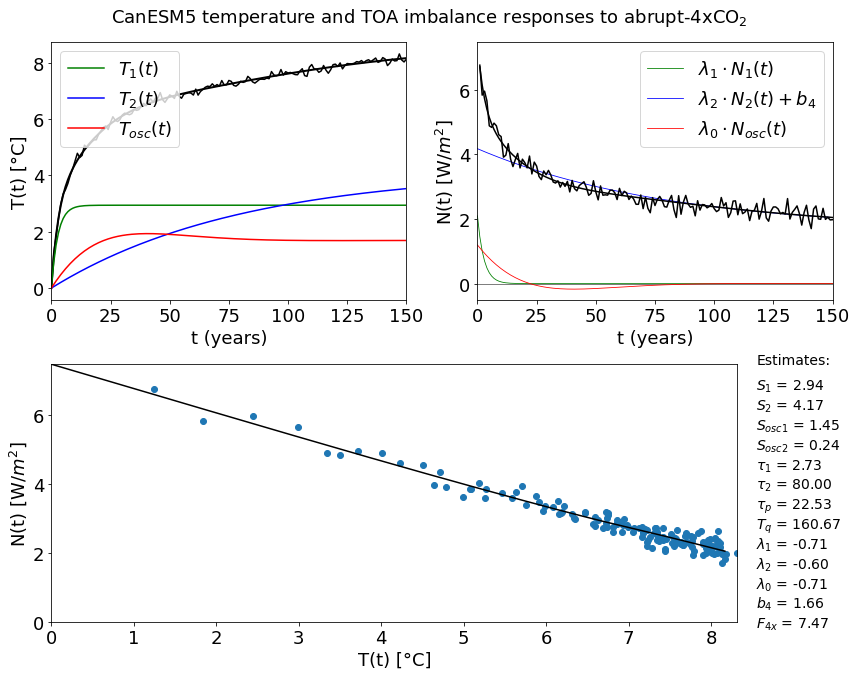

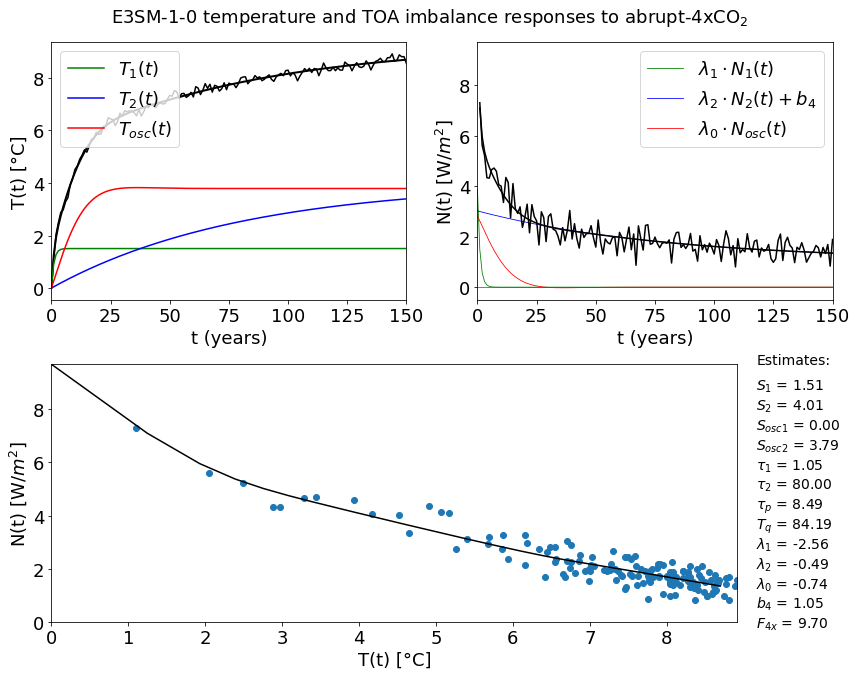

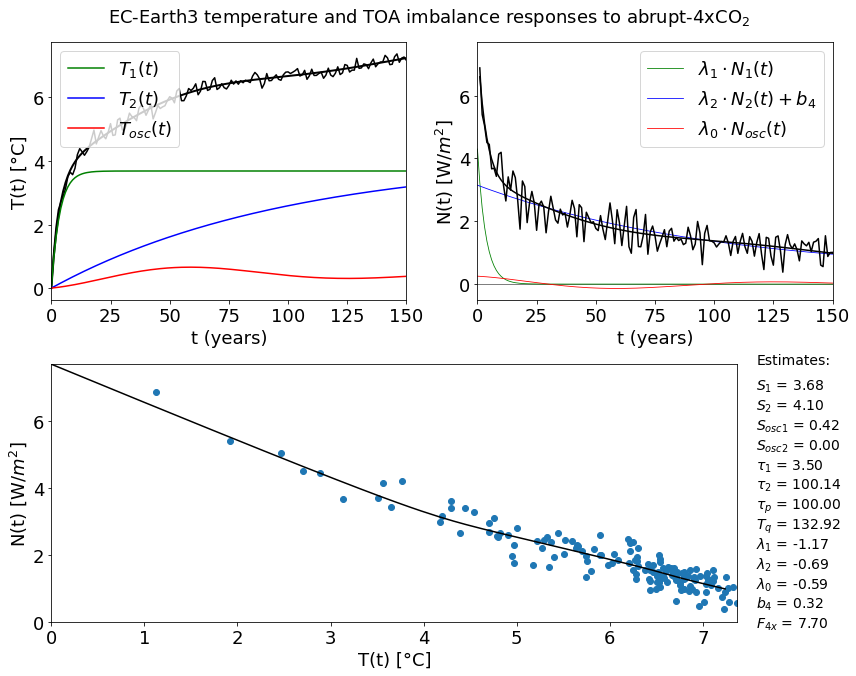

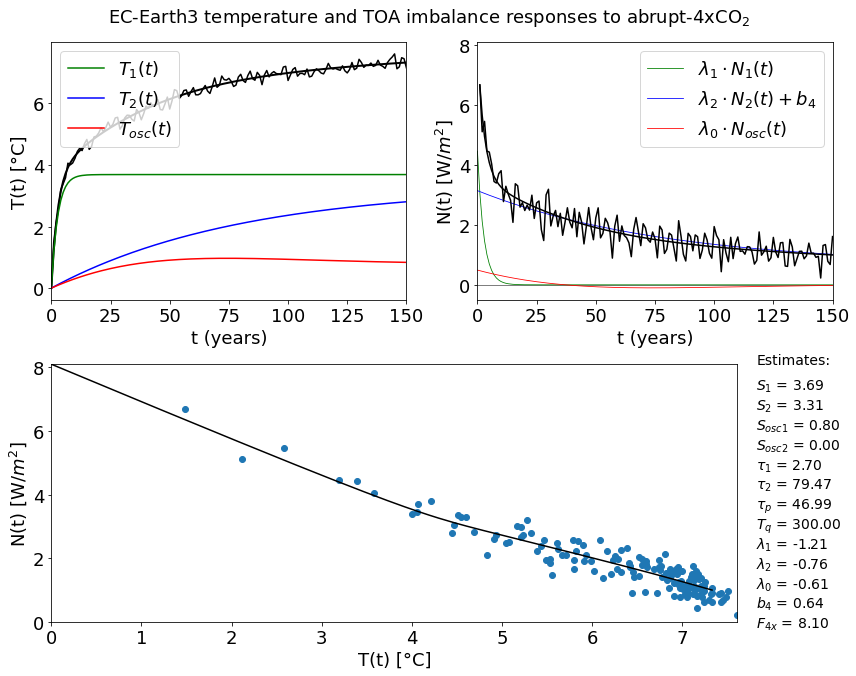

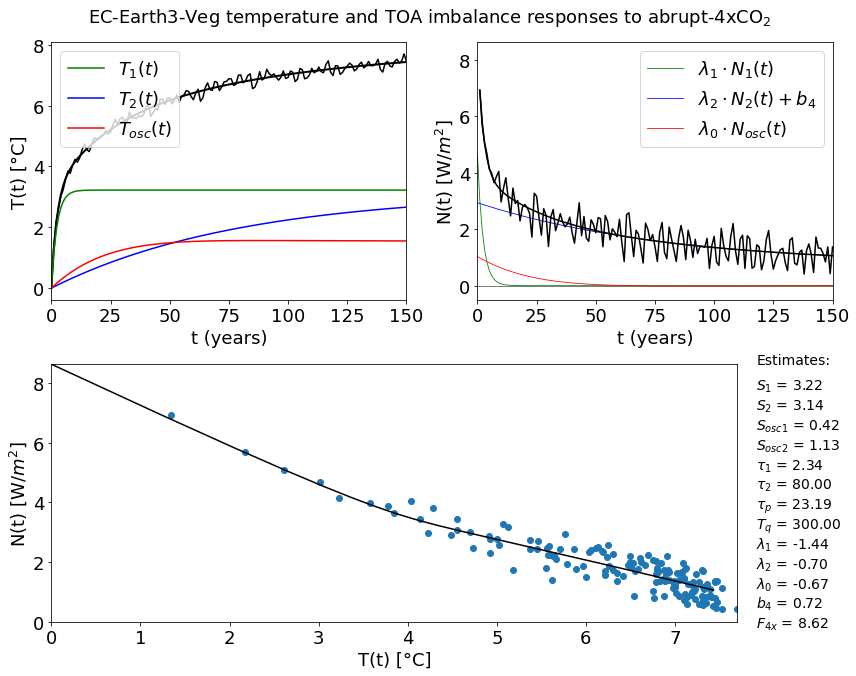

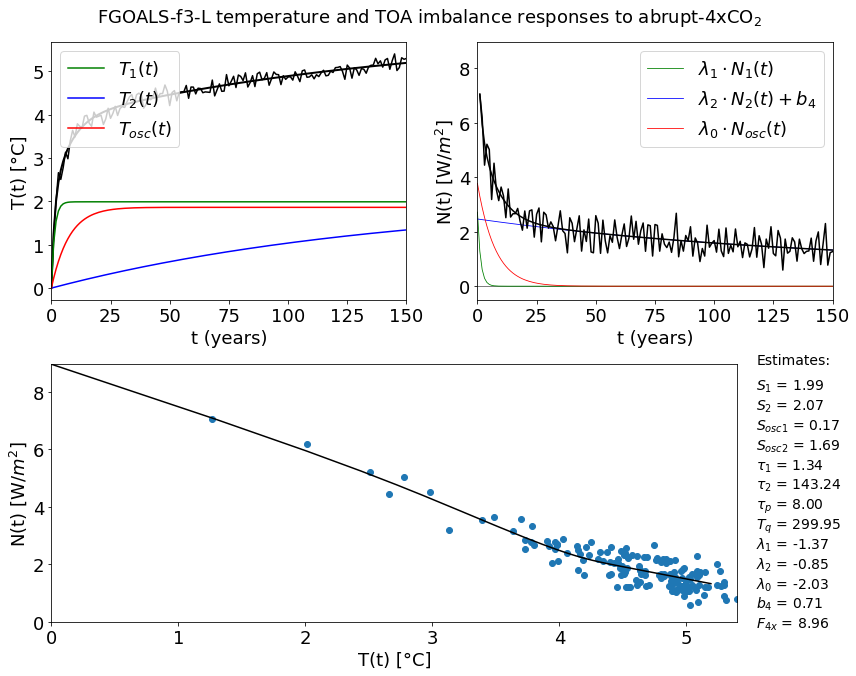

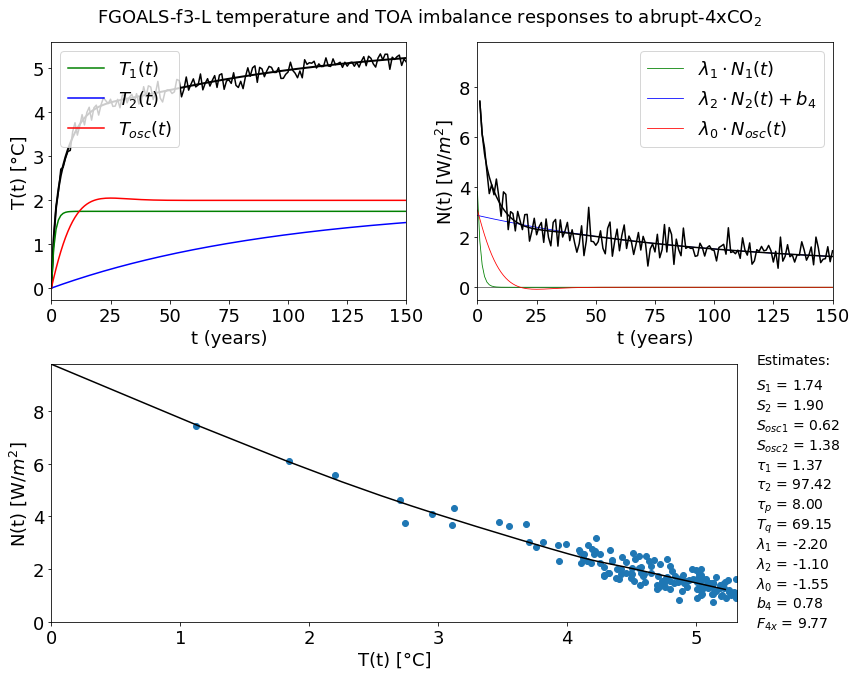

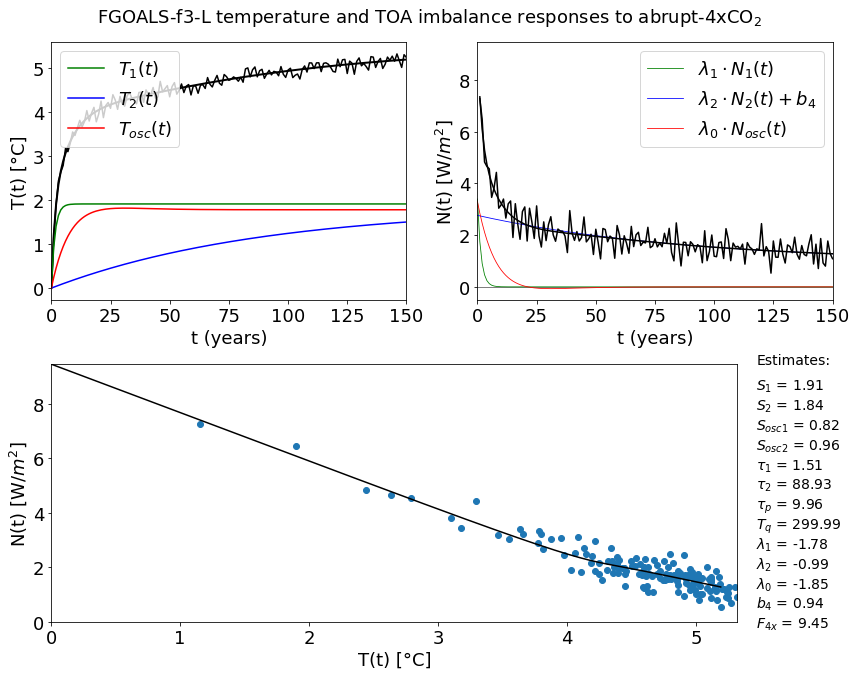

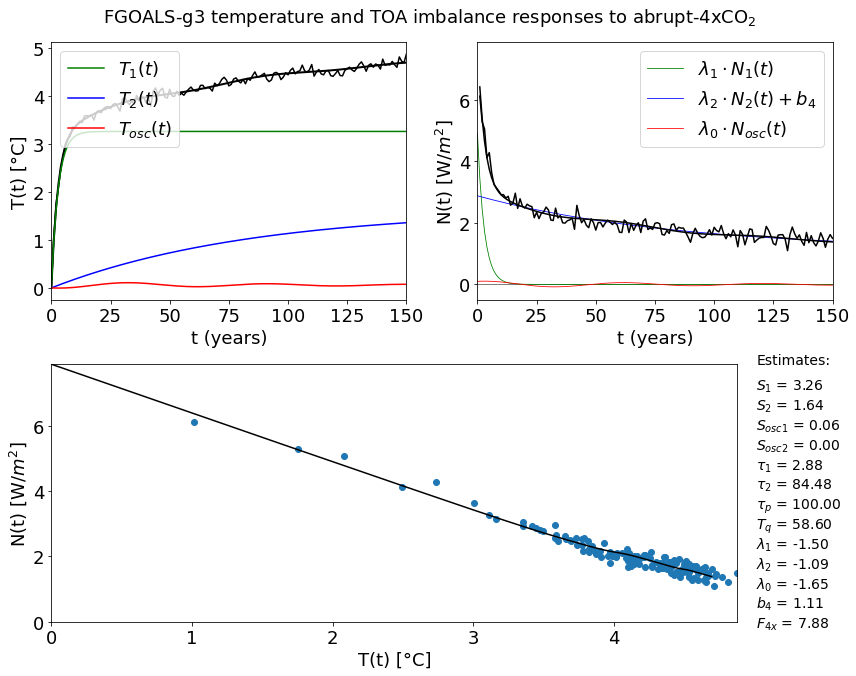

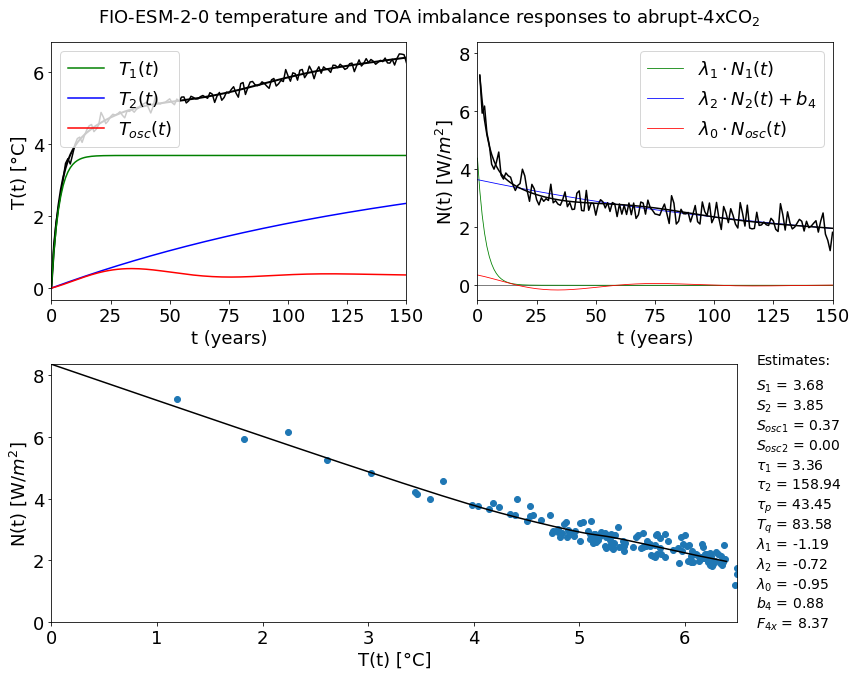

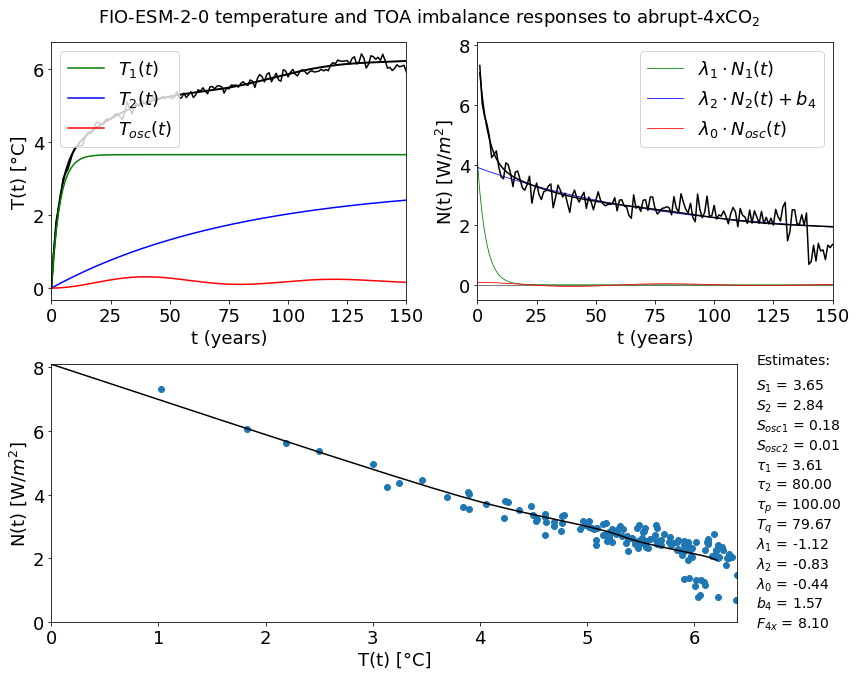

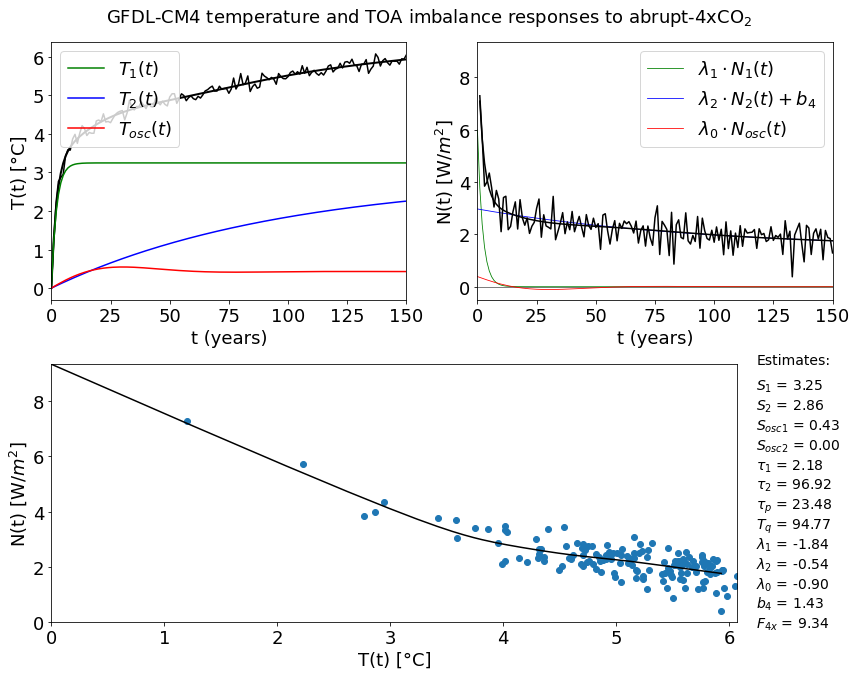

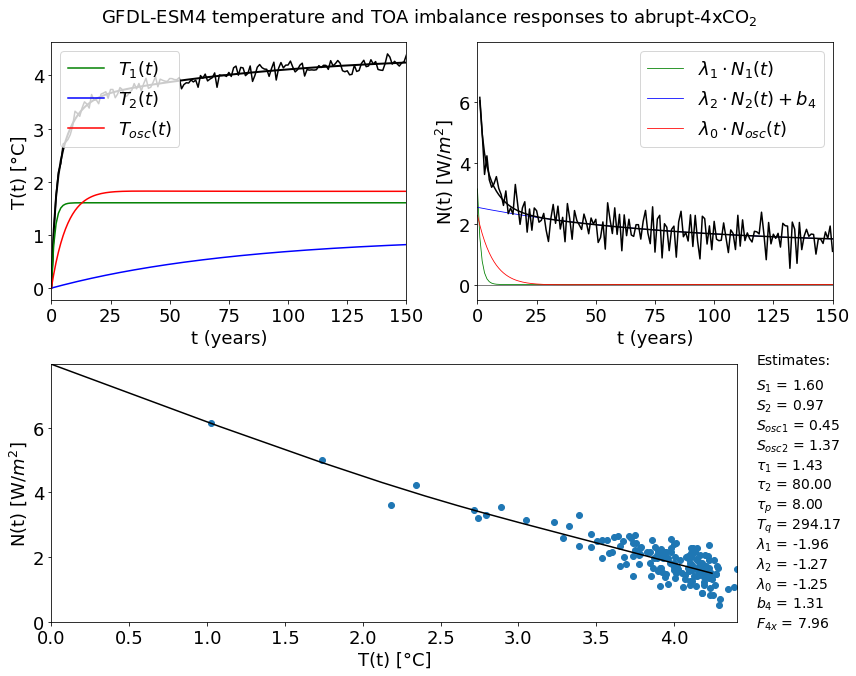

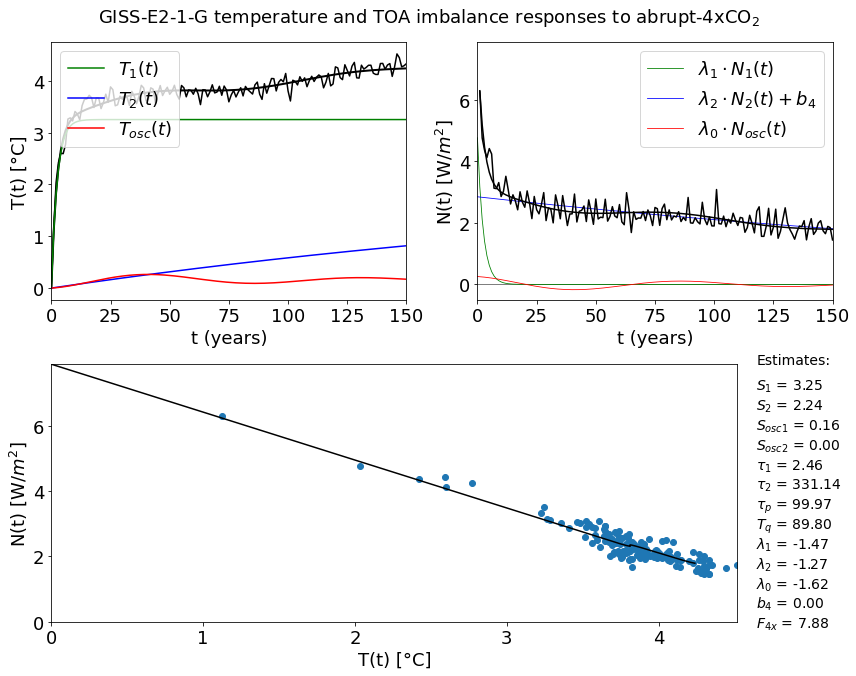

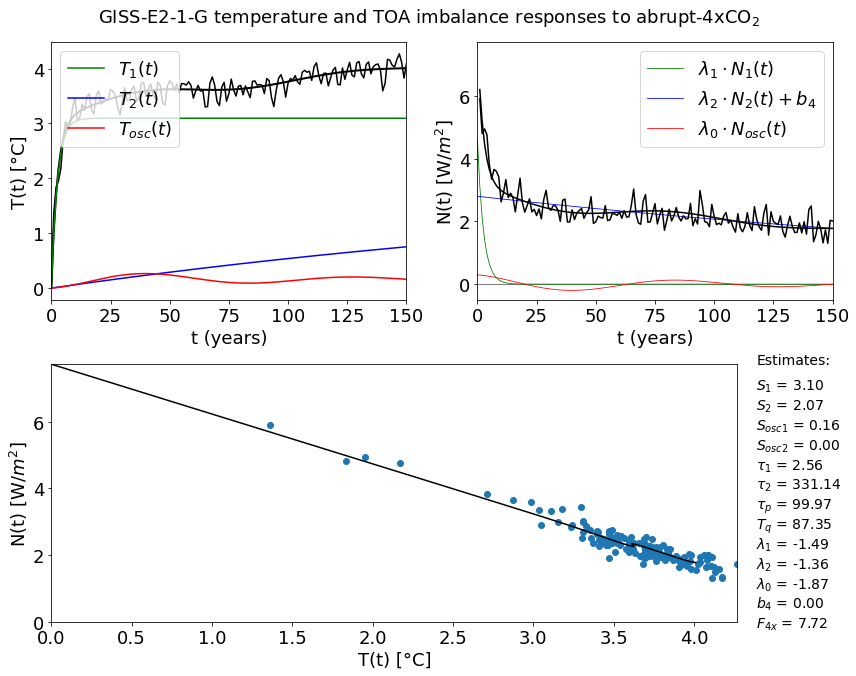

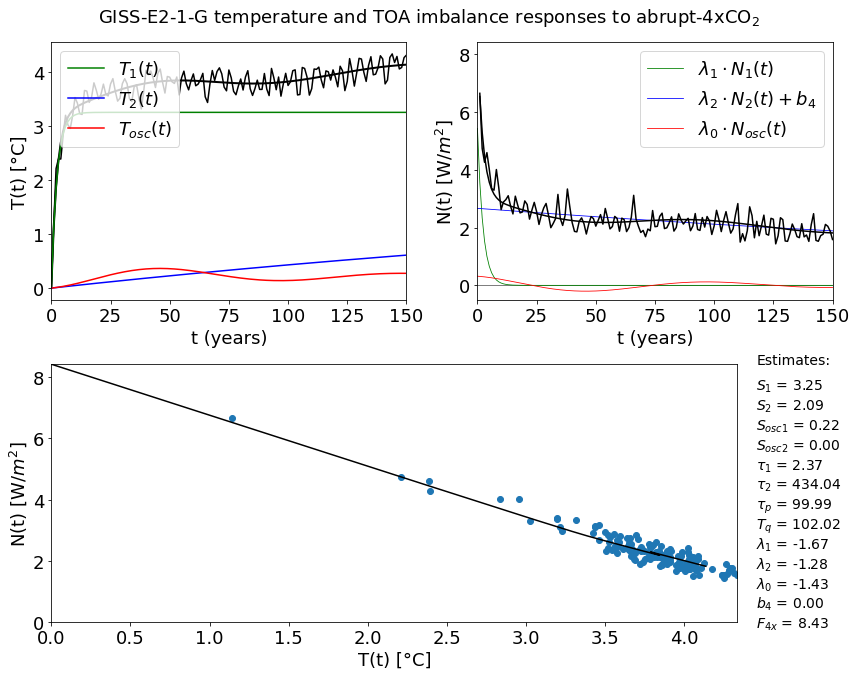

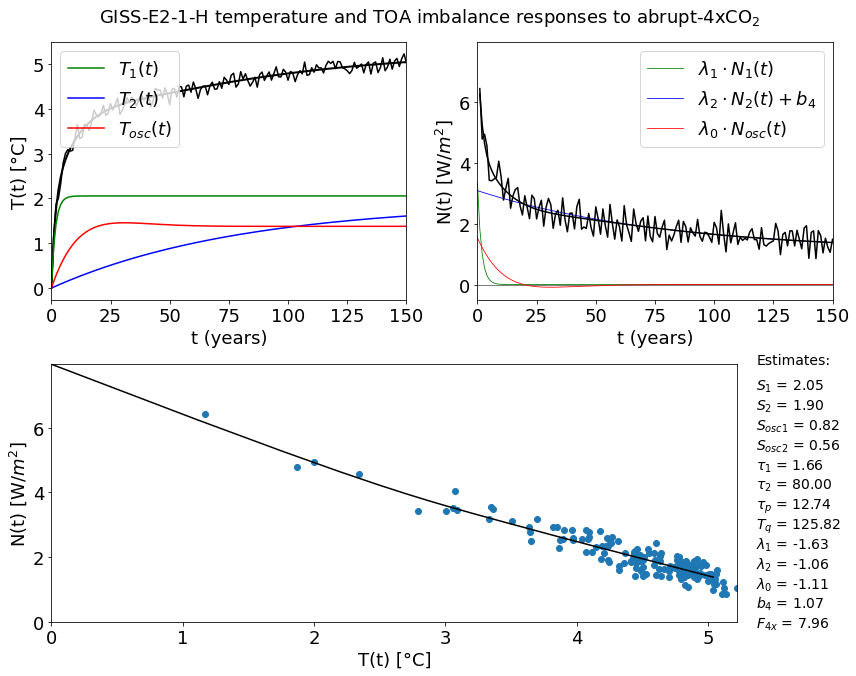

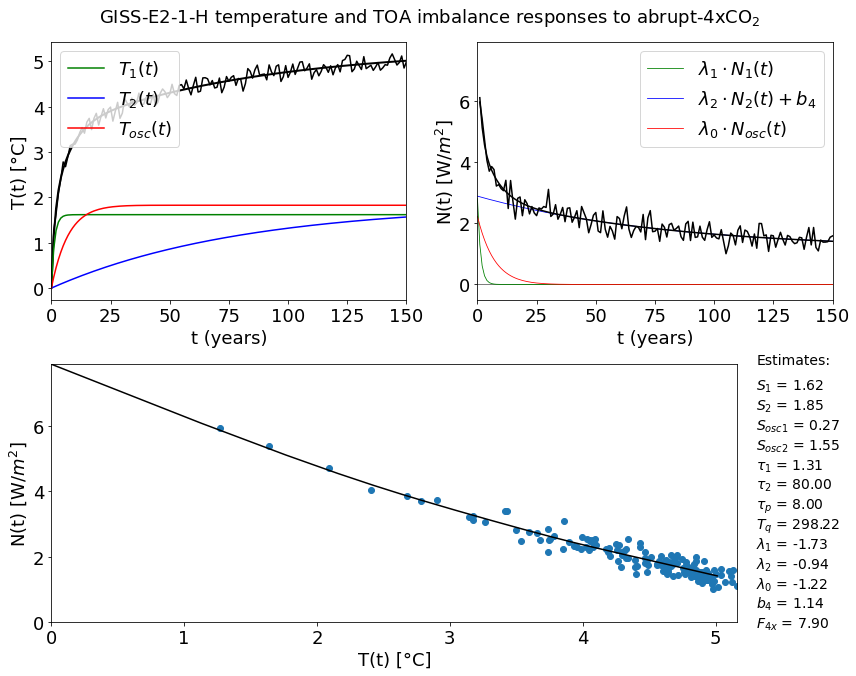

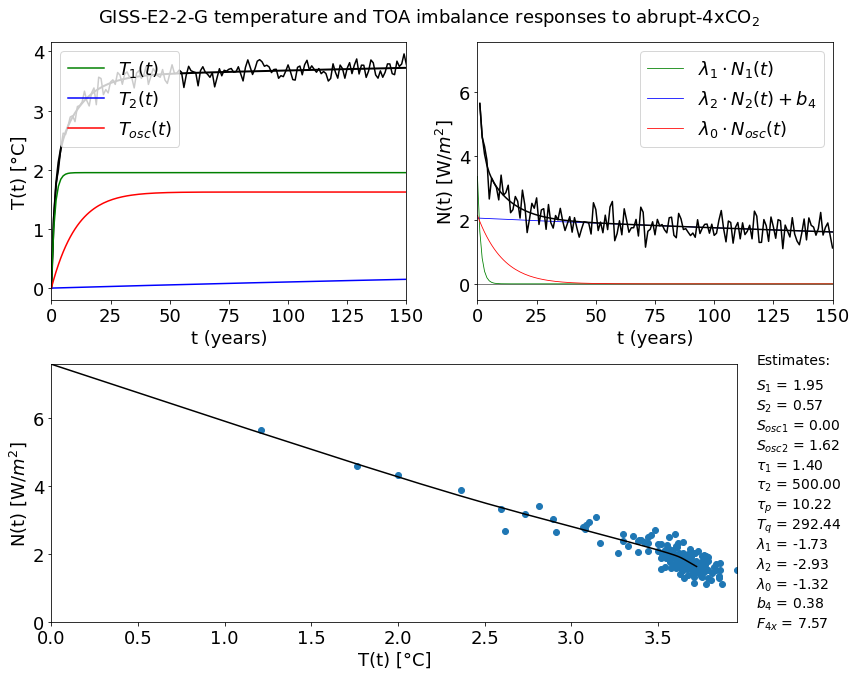

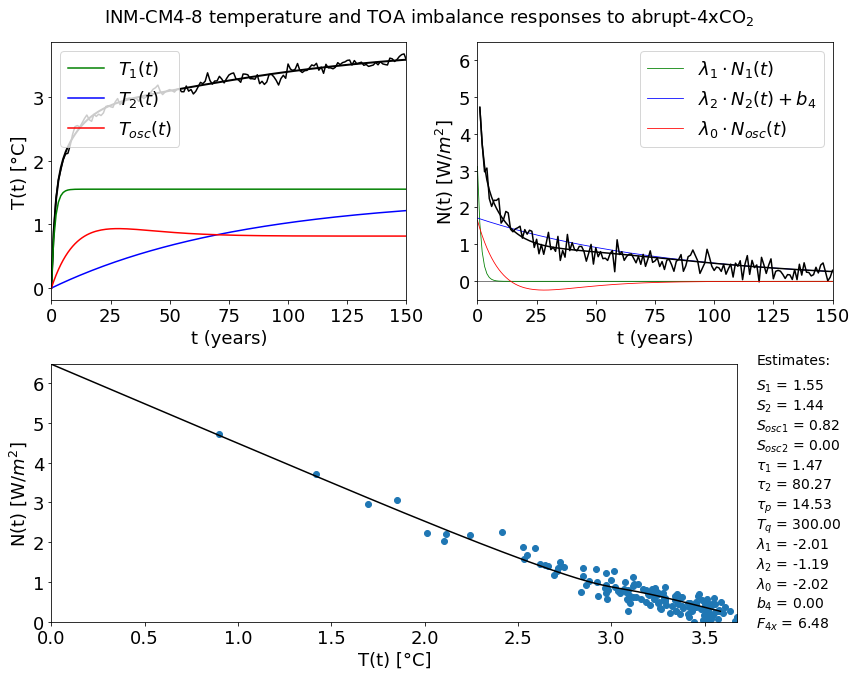

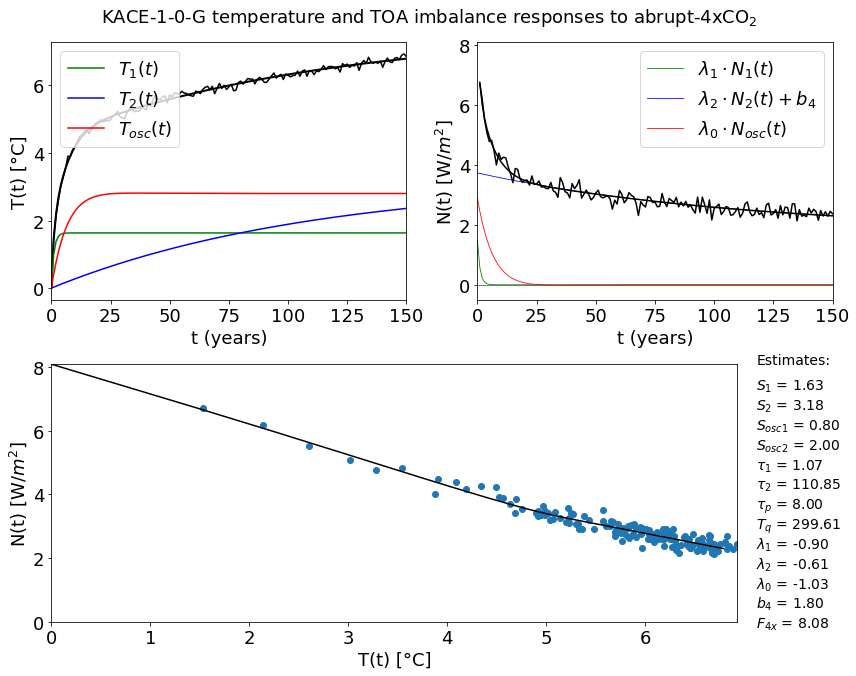

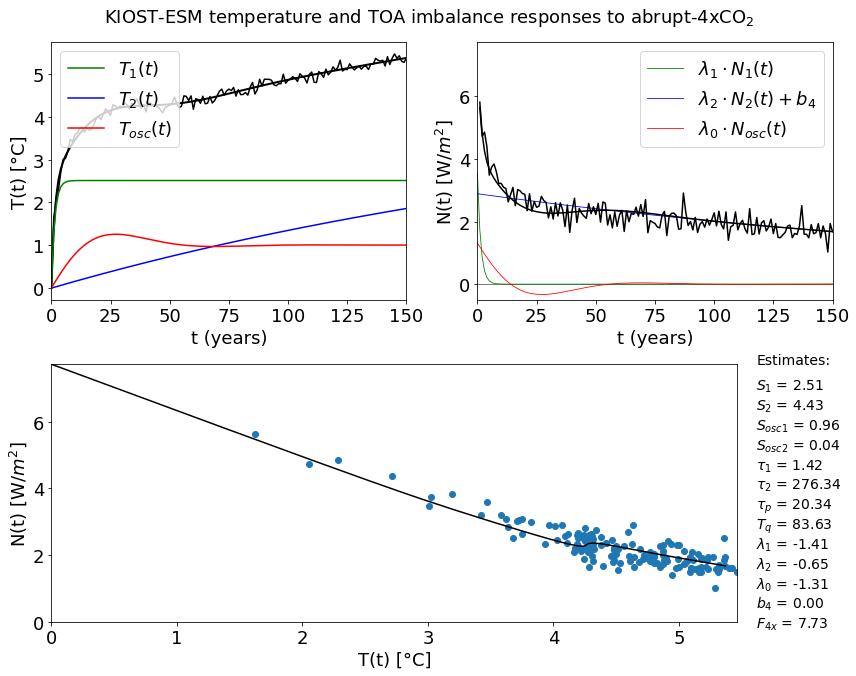

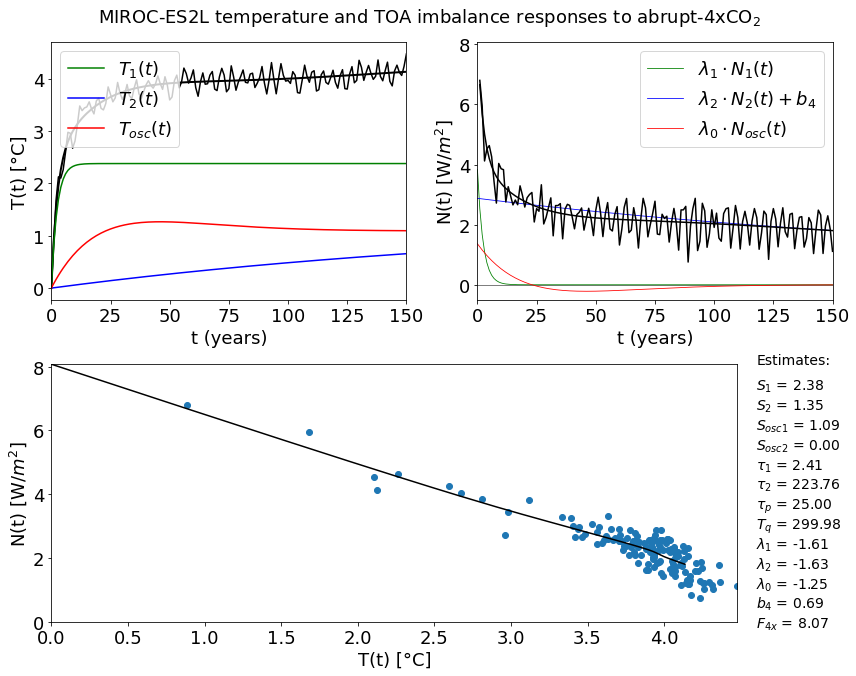

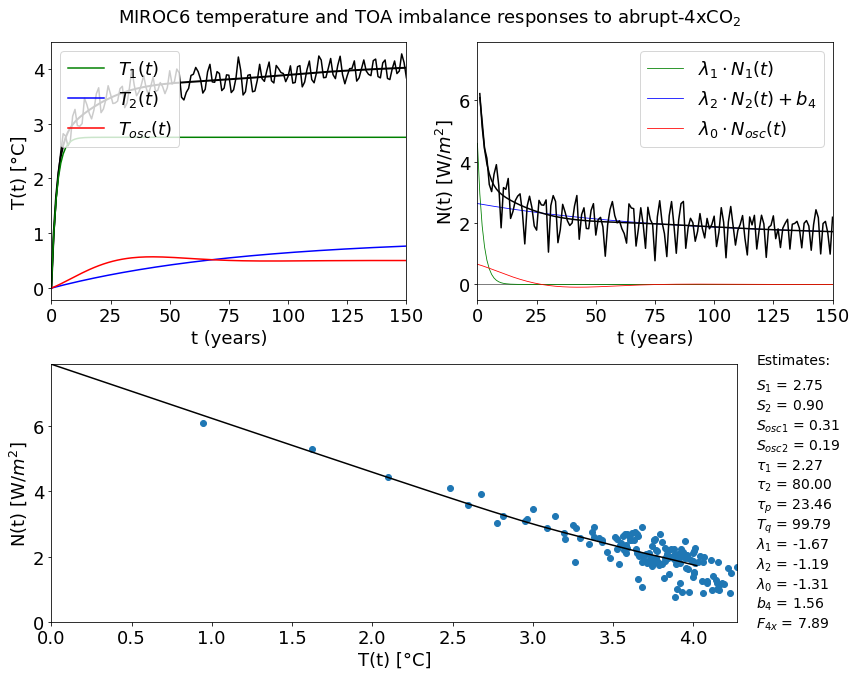

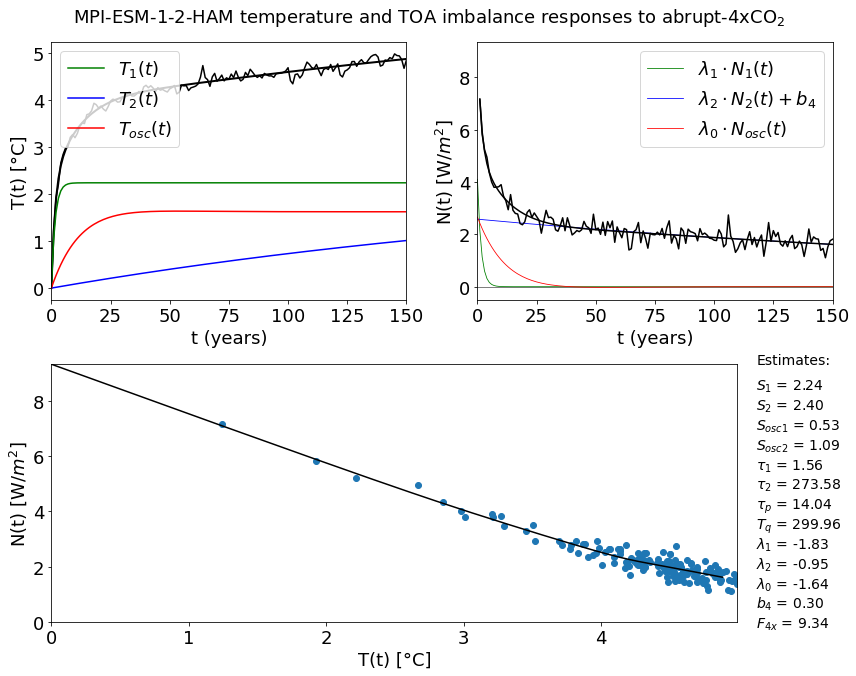

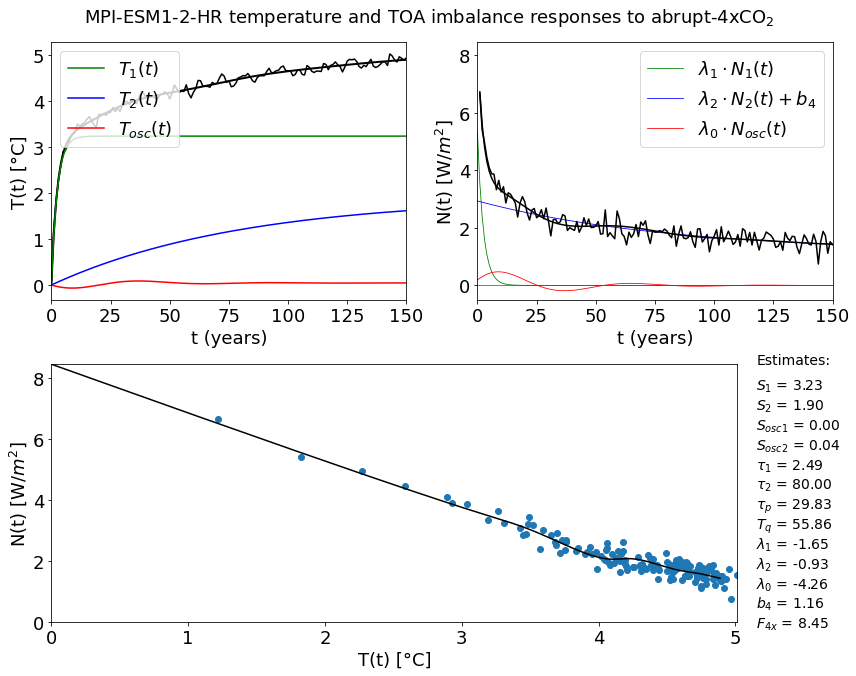

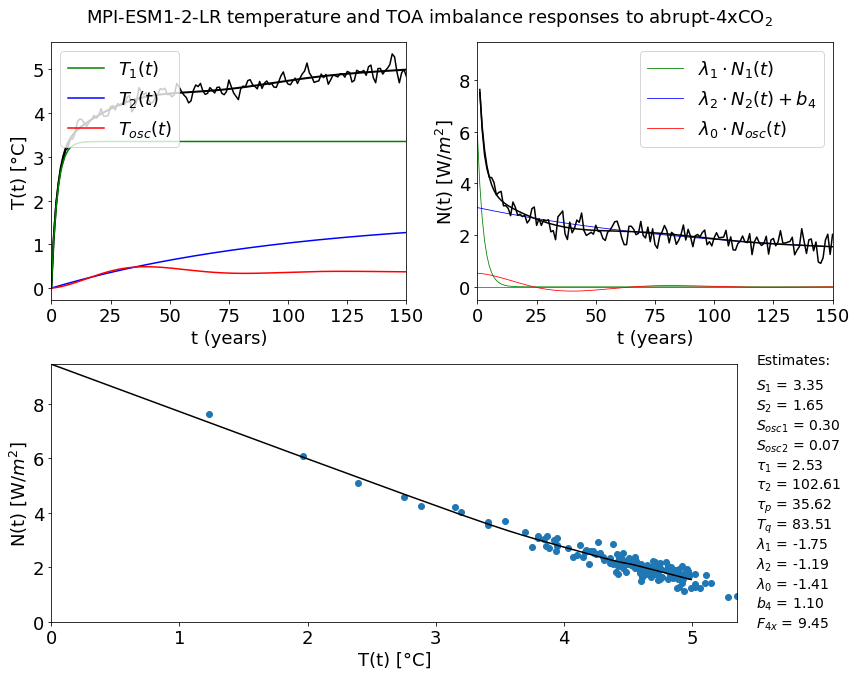

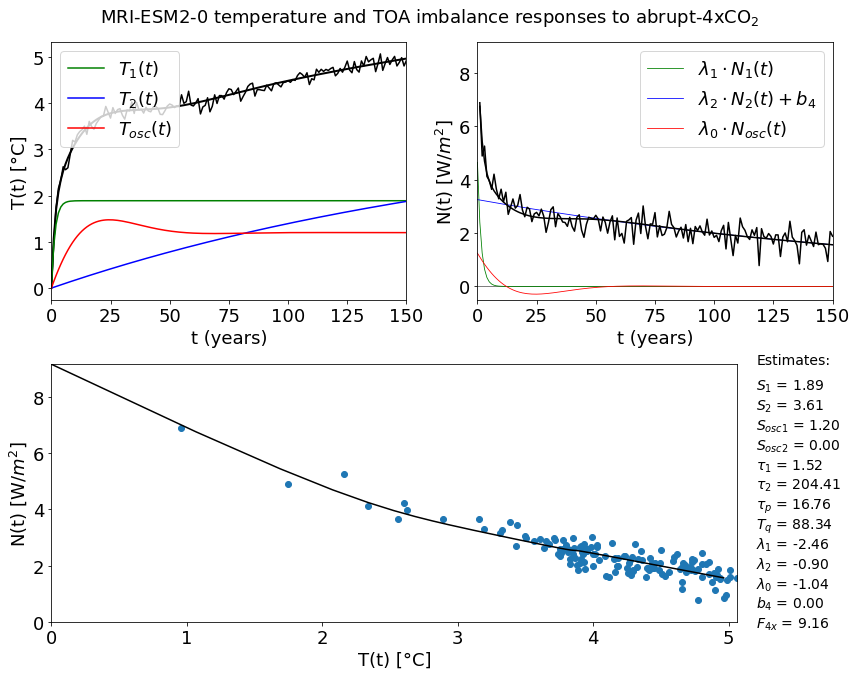

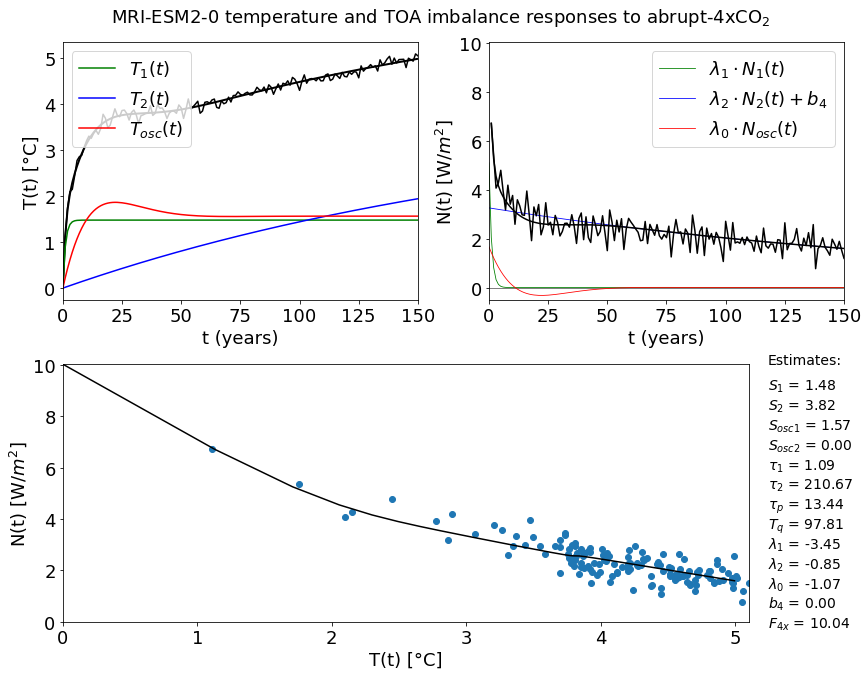

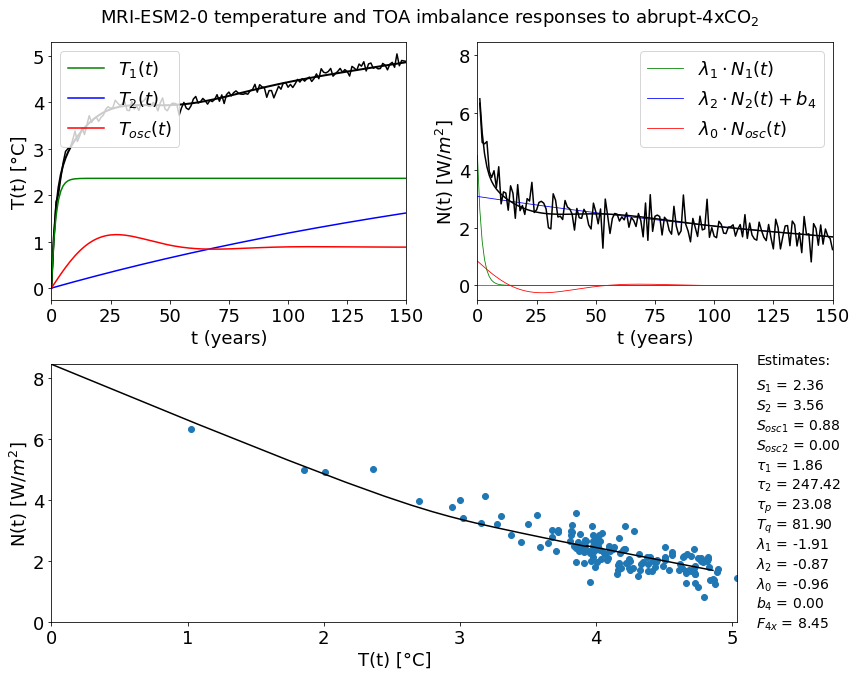

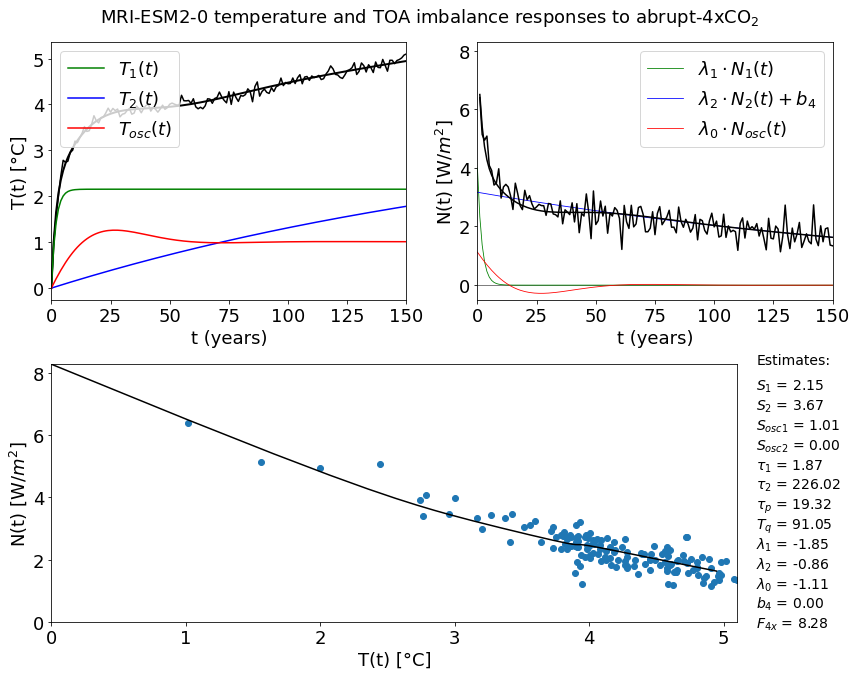

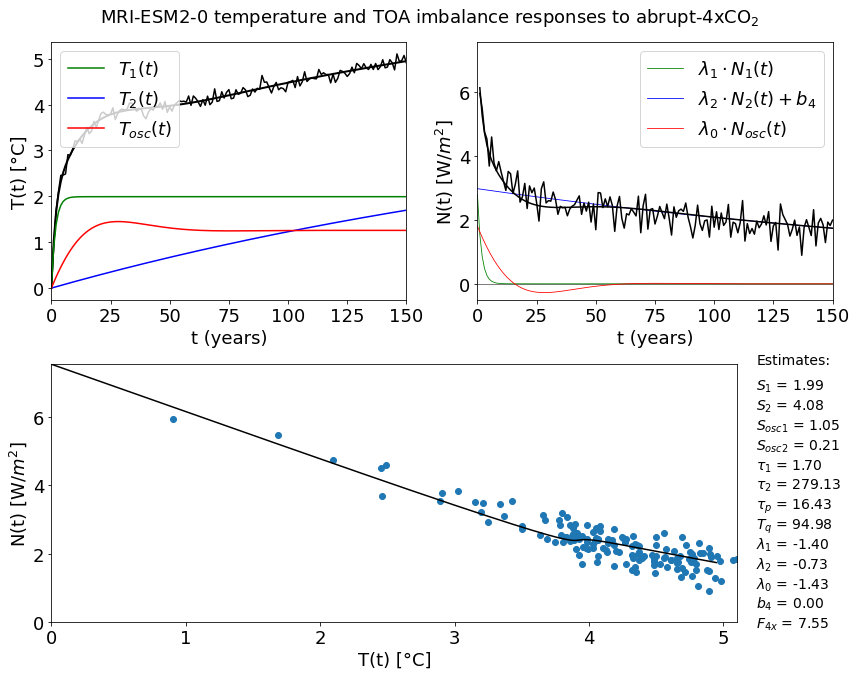

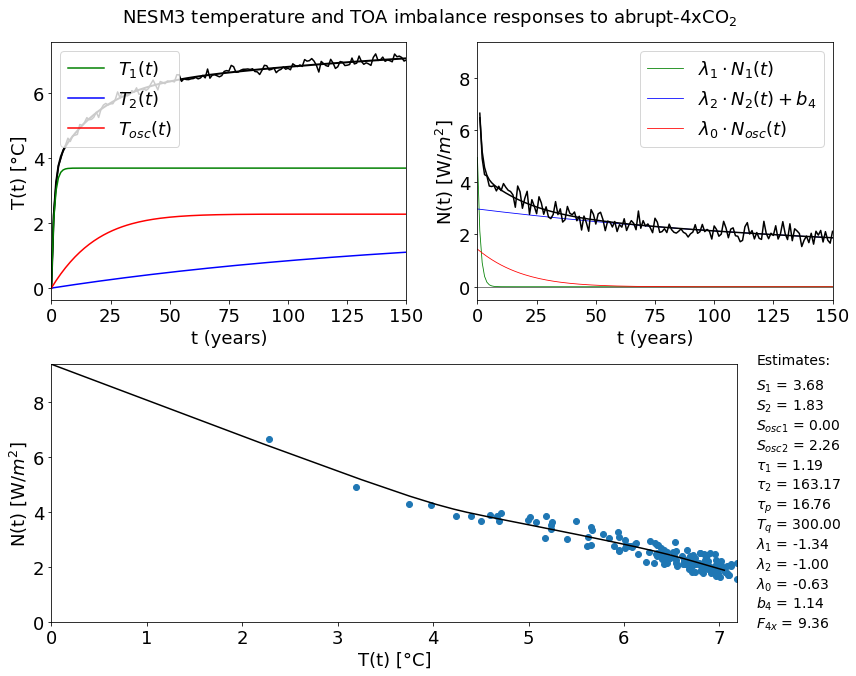

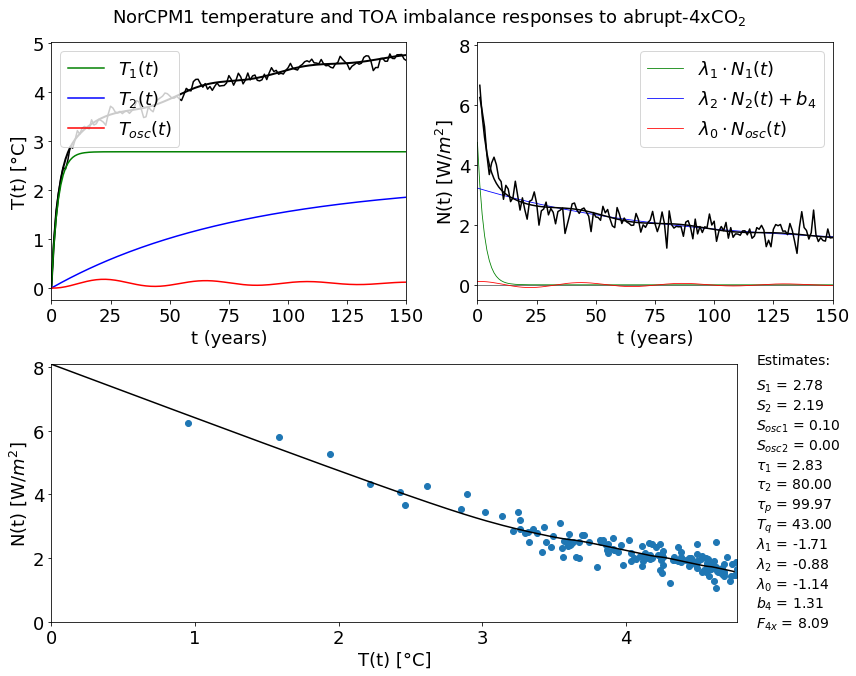

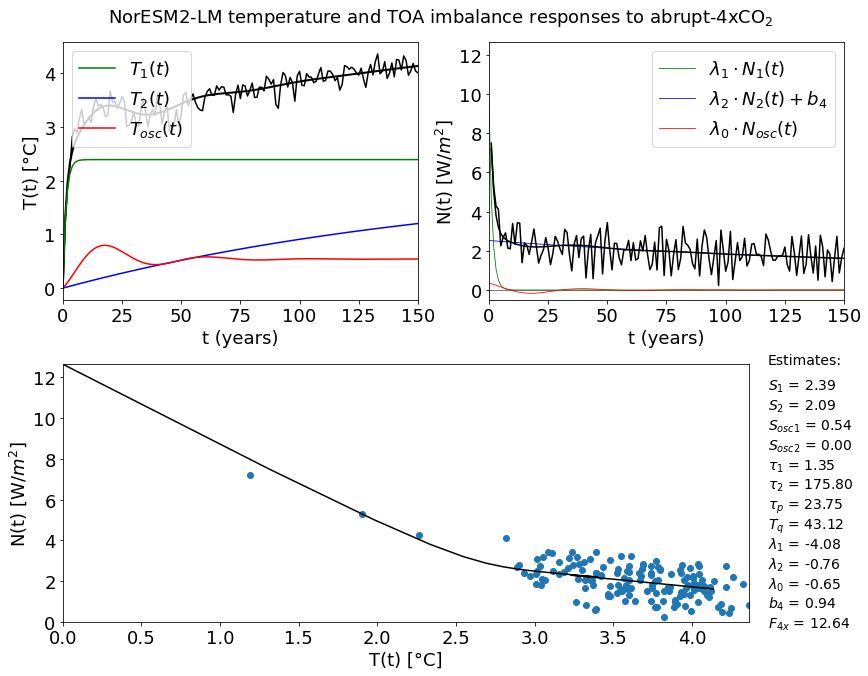

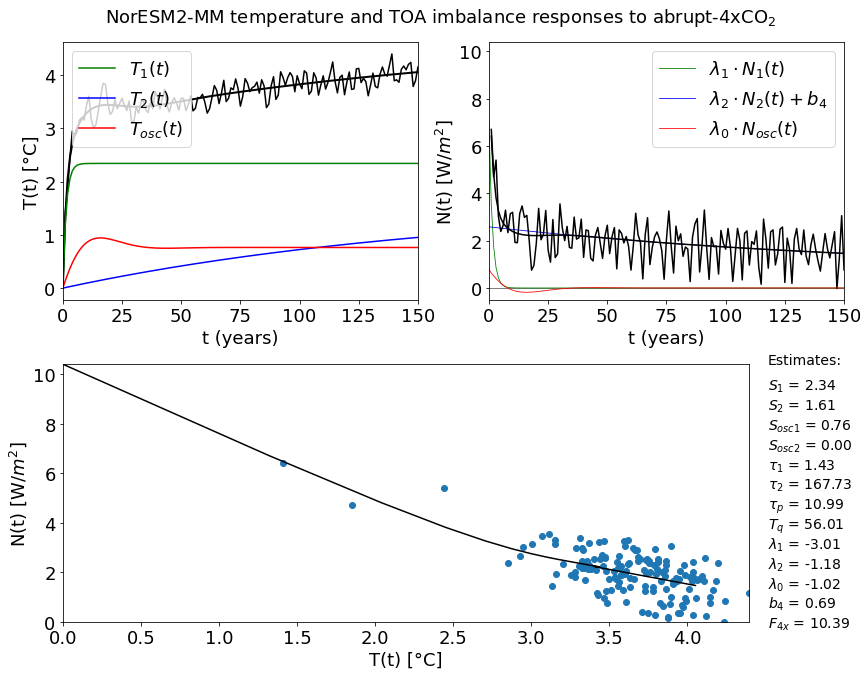

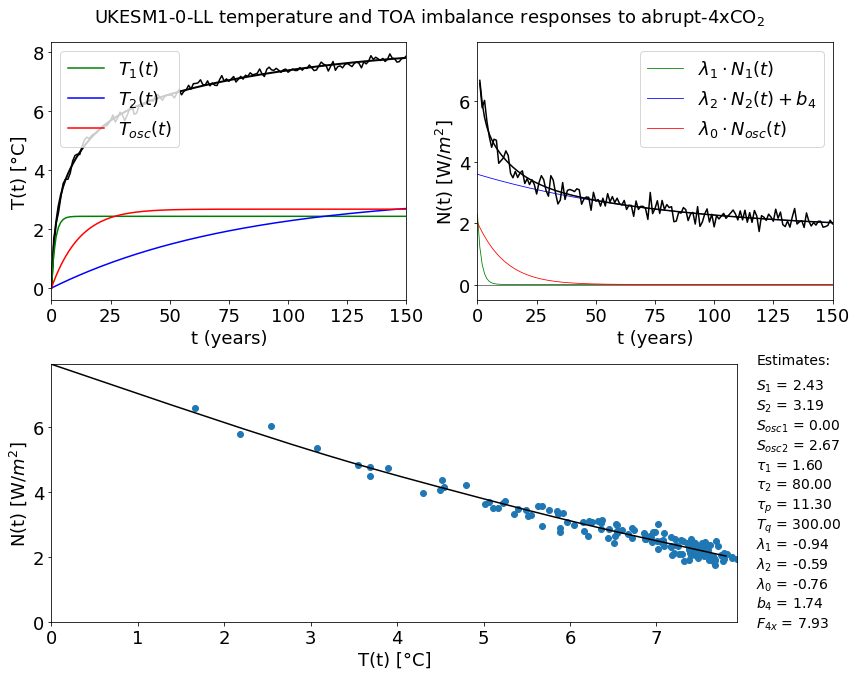

In [17]:
for model in member_dict:
#for model in ['ACCESS-CM2']:
#for model in ['GISS-E2-1-G']:
#for model in ['INM-CM4-8']:
    print(model)
    for member in member_dict[model]:
        #print(member)

        # load data
        filename = model + '_' + exp + '_' + member + '_anomalies.txt'
        file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)

        data = pd.read_table(file, index_col=0, sep = ',')
        data = data.dropna().reset_index()

        deltaN = data['rsdt'] - data['rsut'] - data['rlut']
        deltaT = data['tas']
        if len(deltaT)<150:
            continue

        deltaT = deltaT[:150]; deltaN = deltaN[:150] # if data is longer than 150 years, use only the first 150 years
        if model  == 'CIESM':
            deltaT = deltaT[:-10]; deltaN = deltaN[:-10]
        years = np.arange(1,len(deltaT)+1)
        p_lim = 1 - 0.95;

        parameters_names = ['taup', 'Tq', 'tau1', 'tau2', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'F2x', 'T2x','rnorm']
        df_par = pd.DataFrame(columns=parameters_names)

        # for deltaT we also have the information that deltaT(0) = 0. Include this:
        deltaT0 = np.concatenate(([0],deltaT))
        years0 = np.concatenate(([0],years))
        
        p_50 = np.polyfit(deltaT[-70:],deltaN[-70:],deg = 1)
        maxT4x = -p_50[1]/p_50[0]
        
        gmodel.set_param_hint('S1', value=3, min=0, max=10)
        gmodel.set_param_hint('S2', value=3, min=0, max=10)
        gmodel.set_param_hint('Sosc1', value=0.5, min=0, max=6.0)
        gmodel.set_param_hint('Sosc2', value=0.5, min=0, max=6.0)
        gmodel.set_param_hint('tau1', value=4, min=1, max=8)
        gmodel.set_param_hint('taup', value=40, min=8, max=100)
        gmodel.set_param_hint('Tq', value=70, min=40, max=300)
        tau2_max = 500; 
        sumS = 2*maxT4x # just a random initial value
        
        while sumS >= 0.99*maxT4x: # reduce longest response time to reduce the response
            gmodel.set_param_hint('tau2', value=100, min=80, max=tau2_max)
            result = gmodel.fit(deltaT0, t=years0, method = 'leastsq')
            S_1 = result.best_values['S1']; S_2 = result.best_values['S2']; S_osc1 = result.best_values['Sosc1']; S_osc2 = result.best_values['Sosc2'];
            sumS = S_1 + S_2 + S_osc1 + S_osc2
            tau2_max = tau2_max*0.99
        
        #print('tau2_max reduced to:', tau2_max/0.99)    
            
        Tosc = oscmodel.eval(result.params, t=years0); Texp1 = expmodel1.eval(result.params, t=years0); Texp2 = expmodel2.eval(result.params, t=years0)
        
        parameters = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
        estimates = [result.best_values[par] for par in parameters]
        tau_1 = result.best_values['tau1']; tau_2 = result.best_values['tau2']; tau_p = result.best_values['taup']; T_q = result.best_values['Tq']
        
        
        
        p_lim = 1 - 0.95; 
        timesplit2 = np.int(np.ceil(-tau_2*np.log(p_lim))) # time measured in years
        timesplit1 = np.int(np.ceil(-tau_1*np.log(p_lim)))
        
        
        ### Estimate TOA imbalance response ###

        # model evaluated with and without year 0 
        oscN_0 = oscNmodel.eval(result.params, t=years0); oscN = oscNmodel.eval(result.params, t=years);
        expN1_0 = expNmodel1.eval(result.params, t=years0); expN1 = expNmodel1.eval(result.params, t=years);
        expN2_0 = expNmodel2.eval(result.params, t=years0); expN2 = expNmodel2.eval(result.params, t=years)
        
        def TOAimb_model(expN1_eval, expN2_eval, oscN_eval, fbpar1, fbpar2, fbpar0, b_4):
            return fbpar1*expN1_eval + fbpar2*expN2_eval + fbpar0*oscN_eval + b_4
        
        Nmodel = Model(TOAimb_model, independent_vars=['expN1_eval', 'expN2_eval', 'oscN_eval']);
        
        Nmodel.set_param_hint('fbpar1', value=-1, min=-5, max = 0)
        Nmodel.set_param_hint('fbpar2', value=-1, min=-5, max = 0)
        Nmodel.set_param_hint('fbpar0', value=-1, min=-5, max = 0)
        Nmodel.set_param_hint('b_4', value=2, min=0, max = 10)
        
        Nresult = Nmodel.fit(data = deltaN, expN1_eval = expN1, expN2_eval = expN2, oscN_eval = oscN)
        
        fbp1 = Nresult.best_values['fbpar1']; fbp2 = Nresult.best_values['fbpar2']; fbp0 = Nresult.best_values['fbpar0']; b4 = Nresult.best_values['b_4'];
        print(fbp0)
        f4x = b4 + fbp0*oscN_0[0] + fbp2*expN2_0[0] + fbp1*expN1_0[0]
        #print('Estimated 4xCO2 forcing is', f4x)

        Nmodel_result = Nresult.best_fit
        
        timeindrange1 = np.arange(timesplit1-1)
        timeindrange2 = np.arange(timesplit1-1, timesplit2-1)
        timeindrange3 = np.arange(timesplit2-1, years[-1])

        
        
        ############  Plotting: ############
        fig = plt.figure(figsize = [14,10]);
        
        outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1],  hspace = 0.25) #make outer gridspec
        #make nested gridspecs
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[0], hspace = 0.1)
        gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1], wspace = 0.05, width_ratios = [0.9, 0.1])

        Tax = fig.add_subplot(gs1[0]); Nax = fig.add_subplot(gs1[1]); Gax = fig.add_subplot(gs2[0]); textax = fig.add_subplot(gs2[1]);
        allfig_axes = [Tax, Gax, Nax]
        fig.suptitle(model + ' temperature and TOA imbalance responses to abrupt-4xCO$_2$',fontsize = 18)
        plt.subplots_adjust(top=0.93)

        for axes in allfig_axes:
            axes.tick_params(axis='both',labelsize=18)

        # temperature plot
        Tax.set_xlabel('t (years)',fontsize = 18)
        Tax.set_ylabel('T(t) [°C]',fontsize = 18)
        Tax.set_xlim(min(years0),max(years0))
        Tax.plot(years0, result.best_fit, '-', color = 'black', linewidth = 2)
        Tax.plot(years0, deltaT0, color = 'black')
        Tax.plot(years0, Texp1, color = 'green', label = '$T_1(t)$'); Tax.plot(years0, Texp2, color = 'blue', label = '$T_2(t)$'); Tax.plot(years0, Tosc, color = 'red', label = '$T_{osc}(t)$')
        Tax.legend(fontsize = 18, loc = 'upper left')

        # Gregory plot
        Gax.scatter(deltaT,deltaN)
        Gax.plot(result.best_fit, np.concatenate([[f4x], Nmodel_result]), color = 'black')
        Gax.set_xlabel('T(t) [°C]',fontsize = 18)
        Gax.set_ylabel('N(t) [W/$m^2$]',fontsize = 18)
        Gax.set_xlim(0, np.max([np.max(deltaT), np.max(result.best_fit)]))
        Gax.set_ylim(0, np.max([deltaN[0], f4x]))

        # TOA imbalance plot
        Nax.set_xlabel('t (years)',fontsize = 18)
        Nax.set_ylabel('N(t) [W/$m^2$]',fontsize = 18)
        Nax.axhline(0, color='k', linewidth = 0.5) # horizontal lines

        Nax.set_xlim(0,years[-1])
        #Nax.axvline(x=timesplit2, color = 'black'); Nax.axvline(x=timesplit1, color = 'black')
        
        #if S_1>0.01: 
        dN1 = deltaN - fbp0*oscN - b4 - fbp2*expN2
        #Nax.plot(years, dN1, color = 'lightgray'); #Nax.plot(years[timeindrange1], dN1[timeindrange1], color = 'black')
        Nax.plot(years0, fbp1*expN1_0, color = 'green', linewidth = 0.8, label = '$\lambda_1 \cdot N_1(t)$'); #Nax.plot(years0[timeindrange1+1], fbp1*expN1_0[timeindrange1+1], color = 'green', linewidth = 2)

        #if S_2>0.01:
        dN = deltaN - fbp2*expN2 - b4
        #Nax.plot(years, dN, color = 'lightgray'); #Nax.plot(years[timeindrange2], dN[timeindrange2], color = 'black')
        Nax.plot(years0, fbp2*expN2_0 + b4, color = 'blue', linewidth = 0.8, label = '$\lambda_2 \cdot N_2(t) + b_4$'); #Nax.plot(years0[timeindrange2+1], fbp2*expN2_0[timeindrange2+1], color = 'blue', linewidth = 2)
        Nax.plot(years, deltaN, color = 'black'); #Nax.plot(years[timeindrange3], deltaN[timeindrange3], color = 'black')
        
        Nax.plot(years, Nmodel_result, color = 'black')
        Nax.plot(years0, fbp0*oscN_0, color = 'red', linewidth = 0.8, label = '$\lambda_0 \cdot N_{osc}(t)$');# Nax.plot(years0[timeindrange3+1], b4 + fbp3*oscN_0[timeindrange3+1], color = 'red', linewidth = 2); 
        Nax.set_ylim(-0.5,np.max([deltaN[0], f4x]))
        #print(np.max([deltaN[0], f4x]), deltaN[0])
        Nax.legend(fontsize = 18)

        # print out estimates in the last "plot"
        textax.axis('off');
        esttoshow = [S_1, S_2, S_osc1, S_osc2, tau_1, tau_2, tau_p, T_q, fbp1, fbp2, fbp0, b4, f4x]
        textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', '$T_q$', '$\lambda_1$', '$\lambda_2$', '$\lambda_0$', '$b_4$', '$F_{4x}$']
        textax.text(0,1, 'Estimates:', fontsize=14)
        for (ind, estimate) in enumerate(esttoshow):
            textax.text(0,0.9-ind/len(esttoshow),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14)
        
        
        
        #Gax.text(0.85, 0.9, np.round(maxT4x,2), fontsize=14, transform=Gax.transAxes)
        #Gax.text(0.85, 0.8, np.round(S_1+S_2+S_osc1+S_osc2,2), fontsize=14, transform=Gax.transAxes)
        # if temperature response of osc is generally positive, then we could go back to parameter estimation in Gregory plot
            
        # save parameters?
        p1 = np.polyfit(deltaT,deltaN,deg = 1)
        GregoryF2x = p1[1]/2; GregoryT2x = -p1[1]/(2*p1[0])
        
        columnnames = ['member', 'tau_1', 'tau_2', 'tau_p', 'T_q', 'S_1', 'S_2', 'S_osc1', 'S_osc2', 'b_1', 'b_2', 'b_3', 'b_4', 'F2x','GregoryF2x','GregoryT2x'];
        pars = np.concatenate((member, tau_1, tau_2, tau_p, T_q, S_1, S_2, S_osc1, S_osc2, -S_1*fbp1, - S_2*fbp2,  - (S_osc1 + S_osc2)*fbp0, b4, f4x/2, GregoryF2x, GregoryT2x), axis=None)
        dataframe = pd.DataFrame([pars], index = [model], columns=columnnames)

        # if file is not already created, create a new file to store the results in:
        filename = 'best_estimated_osc_parameters.txt'
        if os.path.isfile('../Estimates/' + filename) == False:
            dataframe.to_csv('../Estimates/' + filename, sep='\t')
        else: # if file exists already, load instead exising file and append results: 
            loaded_dataframe = pd.read_table('../Estimates/' + filename,index_col=0)
            #if (loaded_dataframe.index == model).any():
                #loaded_dataframe = loaded_dataframe.drop([model]) # if model already has a row that I want to remove
            loaded_dataframe = loaded_dataframe.append(dataframe)

            # write them to a file:
            #if exp == 'abrupt-4xCO2' and member in ['r1i1p1f1', 'r1i1p1f2']: # keep only first member of 4xCO2 right now
            loaded_dataframe.to_csv('../Estimates/' + filename, sep='\t')    
            
            
            